# Natural Language Processing on Tweets: Sentiment Analysis and text classification

In [628]:
from __future__ import print_function
from textblob import TextBlob, Word
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import string
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import os
import numpy as np
import operator
from random import shuffle
from collections import Counter
import sys
import re
import json
from prettytable import PrettyTable
from IPython.display import HTML, display
import datetime
from math import sqrt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix

# Set Seaborn defaults
sns.set()
%matplotlib inline
pd.set_option("display.precision", 6)
pd.options.display.max_colwidth = 500
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 150
mpl.rcParams['figure.autolayout'] = True

# Global variables
data_dir = "../data"
pictures_path = os.path.join("../Pictures", "11.NLP")
tweets_path = "../lib/GetOldTweets-python/out/completed"

In [42]:
# Model classes
class Tweet:
    def __init__(self, tweet_id, tweet_dict):
        self.tweet_id = tweet_id
        self.tweet_dict = tweet_dict
        
    def __eq__(self, other):
        if isinstance(other, Tweet):
            return self.tweet_id == other.tweet_id
        return NotImplemented
    
    def __ne__(self, other):
        x = self.__eq__(other)
        if x is not NotImplemented:
            return not x
        return NotImplemented
    
    def __hash__(self):
        return hash(self.tweet_id)

In [43]:
# Utility functions
def get_relative_percentage(n,m):
    return n*100.0/m

def read_large_file(file_object):
    while True:
        data = file_object.readline()
        if not data:
            break
        yield data.rstrip('\n')
        
# Extract tweets given a specific hashtag (include also retweeted/quoted tweets)
def get_tweets(hashtag):
    tweets_filename = os.path.join(tweets_path,"tweets_#" + hashtag + "_2013-09-01_2016-12-31.json")
    tweets = set()
    with open(tweets_filename) as fin:
        for line in read_large_file(fin):
            tweet_dict = json.loads(line)
            tweet_id = np.int64(tweet_dict["id_str"])
            t = Tweet(tweet_id, tweet_dict)
            for special in ["retweeted_status","quoted_status"]:
                if special in tweet_dict:
                    tweets.add(Tweet(np.int64(tweet_dict[special]["id_str"]), tweet_dict[special]))
                    t.tweet_dict.pop(special)
            tweets.add(t)
    print("Imported %d tweets from %s" %(len(tweets),tweets_filename))
    return tweets

def print_pretty_table(rows, column_names):
    t = PrettyTable(column_names)
    for r in rows:
        t.add_row(r)
    print(t)


Sentiment Analysis and Tweets text classification is a common task among NLP-ers although highly subject to misclassification risks due to the ambiguous nature of the text content and the actual sentiment they want to transmit. It's not uncommon, indeed, to see sarcastic Tweets whose actual sentiment is not trivial to be inferred by a classifier that has been trained on pure positive/negative/neutral emotions. 

With my analysis, I want to achieve the following goals:
1. **Compute Sentiment Analysis Score for different sets of hashtags**: Pick sets of Tweets of hashtags that are strongly left/right leaning (e.g. #ImWithHer is left leaning or democrats/liberals, whereas #MAGA is right-leaning or republicans/conservatives) and compute average sentiment score (first by using the built-in classifier provided by TextBlob pre-trained on movies reviews, secondly (*if time allows it*) using a custom classifier trained ad-hoc on actual Tweets) for each of them and show Sentiment Score distribution with boxplots where observations are individual tweets; show basic stats (e.g. percentage of tweets with positive/negative sentiment, show the top positive/negative tweets);
2. **Political Text classification**: Build corpus of tweet texts for each category (Right, Left for simplicity) and build classifier to predict political orientation (polarity) by content of tweet, using bag-of-words/TF-IDF approaches. This would not be a perfect political tendency classifier, mainly because the content of each tweet related to a certain hashtag might not entirely reflect an opinion on *that* hashtag.

Predicting political tendency of user based both on the content of the tweets and its role and properties in the network structure is a task that requires more complicated steps and an accurate methodology for which I have no time left to be spent.

## 1. Sentiment Analysis
I've chosen to work mainly with the `TextBlob` Python package, which basically exposes a wrapper for the well-known `NLTK` (Natural Language ToolKit) package, largely adopted for Natural Language Processing tasks.

### 1.1 Pre-Processing
Tweets often include noisy data that ideally should be cleaned up prior to any analysis. Luckily, for the sake of the sentiment analysis, `TextBlob` comes handy as it offers most of the required pre-processing tasks and are already automatically performed when calculating the sentiment score. The pre-processing tasks I would consider include (in order):
- Converting the text to lowercase
- Translation of non-english tweets *(ignored because of performance degradation)*
- URL stripping *(this has already been applied by the script used to download the Tweets)*
- Removing non-ASCII characters, symbols, numbers
- Removing User mentions
- Spell-checking and correction *(ignored because of performance degradation)*
- Removing stopwords
- Filtering out short words (e.g. $len(w) \leq 3$)
- Emoticon detection (already nicely handled by default by `TextBlob`)
- Stemming and lemmatisation, to group together the inflected forms of a word so they can be analyzed as a single item
- Perform POS (Part-Of-Speech) tagging to select only relevant features/tokens (like nouns, verbs, adjectives)

`TextBlob`, luckily, already performs most of the text parsing and pre-processing listed above before computing the sentiment score. However, we still want to perform all of these in order to perform further text analysis. In order to perform sentiment analysis without loosing information provided by punctuation, I define two functions to process the tweets text as defined above. One would be the *baseline cleaner function* (enough prior to carrying out the SA task) and the other one the *advanced cleaning function* (to be used prior to the text classification task).

In [130]:
hashtags = ["imwithher", "makeamericagreatagain"]
hashtags_full = ["ImWithHer", "MakeAmericaGreatAgain"]

In [44]:
%%time
# Read tweets
hashtag_to_tweets = {h:get_tweets(h) for h in hashtags}

Imported 1745238 tweets from ../lib/GetOldTweets-python/out/completed/tweets_#makeamericagreatagain_2013-09-01_2016-12-31.json
Imported 3189115 tweets from ../lib/GetOldTweets-python/out/completed/tweets_#imwithher_2013-09-01_2016-12-31.json
CPU times: user 3min 35s, sys: 11.3 s, total: 3min 47s
Wall time: 3min 46s


Let's first show some basic stats on the tweets, for example which are the most common hashtags that are used along with the main ones:

In [45]:
%%time
extra_hashtags = {}
for h in hashtag_to_tweets:
    extra_hashtags[h] = {}
    for t in hashtag_to_tweets[h]:
        for hashtag in t.tweet_dict["entities"]["hashtags"]:
            if hashtag.lower() == h:
                continue
            if hashtag.lower() in extra_hashtags[h]:
                extra_hashtags[h][hashtag.lower()] += 1
            else:
                extra_hashtags[h][hashtag.lower()] = 1

CPU times: user 19.1 s, sys: 444 ms, total: 19.6 s
Wall time: 19.1 s


In [46]:
for h in extra_hashtags:
    top20 = sorted(extra_hashtags[h].items(), key=operator.itemgetter(1), reverse=True)[:20]
    print_pretty_table(top20, ['Supporting Hashtags (%s)' %h, 'Frequency'])

+---------------------------------------------+-----------+
| Supporting Hashtags (makeamericagreatagain) | Frequency |
+---------------------------------------------+-----------+
|                  trump2016                  |   390190  |
|                  trumptrain                 |   219546  |
|                    trump                    |   145959  |
|                     maga                    |   71601   |
|                  votetrump                  |   50399   |
|                 trumppence16                |   48423   |
|                 alwaystrump                 |   47222   |
|                votetrump2016                |   45655   |
|                wakeupamerica                |   42643   |
|                  teamtrump                  |   38561   |
|                 donaldtrump                 |   36701   |
|                 neverhillary                |   33123   |
|                 americafirst                |   31843   |
|                     tcot              

Let's now define all the functions needed for the pre-processing step:

In [364]:
def drop_keys(dictionary, keys):
    for k in keys:
        dictionary.pop(k)

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

def clean_tweet_baseline(tweet):
    text = tweet["text"]
    # Convert non-English texts to English: translation takes up a lot of execution time
    '''if tweet["lang"] != "en":
        try:
            text = TextBlob(text).translate(from_lang=tweet["lang"], to="en").string
        except:
            pass'''
        
    # Remove handles (user mentions)
    text = remove_pattern(text, r"@[\w]*")
    
    # Remove hashtag symbols (but not full hashtag)
    text = text.replace("#","")
    
    # Remove ReTweet indicator
    text = remove_pattern(text, r"^RT[\s]+|[\s]+RT[\s]+")
    
    # Replace new line character '\n' with space character
    text = text.replace("\n"," ")
    
    # Fix classic slang/internet abbreviations
    abbreviations = [(r'\bthats\b','that is'),(r'\bive\b','i have'),(r'\bim\b','i am'),(r'\bya\b','yeah'),
                     (r'\bcant\b','can not'),(r'\bwont\b','will not'),(r'\bid\b','i would'),(r'wtf','what the fuck'),(r'\bwth\b','what the hell'),
                     (r'\br\b','are'),(r'\bu\b','you'),(r'\bk\b','OK'),(r'\bsux\b','sucks'),(r'\bno+\b','no'),(r'\bcoo+\b','cool'),
                     (r'\blol\b','lot of laughs'),(r'\b4\b','for')]
    for abb in abbreviations:
        text = re.sub(abb[0], abb[1], text, flags=re.IGNORECASE)
        
    # Strip non ASCII characters
    text = "".join((c for c in text if 0 < ord(c) < 127))
    
    # Remove numbers
    text = remove_pattern(text, r'[\d]+')
    
    # Remove HTML symbols (like '&', tabs/spaces etc.)
    text = remove_pattern(text, r'&[\w]*;')
    
    text = text.strip()
    tweet["text"] = text
    return tweet

# Cleaning function needed before text classification task
def clean_tweet_advanced(text):
    cleaned_text = text
    # Convert to lowercase
    cleaned_text = cleaned_text.lower()
    
    # Singularize words (remove plurals)
    cleaned_text = " ".join([w.singularize() for w in TextBlob(cleaned_text).words])
    
    # Filter by relevant POS tags and lemmatize
    pos_tags = [(w,get_wordnet_pos(pos_tag)) for w,pos_tag in TextBlob(cleaned_text).pos_tags if get_wordnet_pos(pos_tag) != '']
    cleaned_text = " ".join([w.lemmatize(pos_tag) for w,pos_tag in pos_tags])
    
    # Remove short words (len <= 3)
    cleaned_text = " ".join([w for w in cleaned_text.split() if len(w.translate({ord(c): None for c in string.punctuation}))>3])
    
    # Remove stop words
    cleaned_text = " ".join([w for w in cleaned_text.split() if w.translate({ord(c): None for c in string.punctuation}) not in set(stopwords.words('english'))])
    
    return cleaned_text.strip()

In order to speed up execution times, I'm forced to skip tweet text translation for non-english tweets, as it takes up a lot of execution time due to the network communication required by the translator. Furthermore, only tweets that actually express a logically complete and reasonable thought may be useful for our analysis, hence short tweets may be discarded. Let's then filter the tweets and include only the ones with english text and that have at least 10 words:

In [48]:
%%time
for h in hashtag_to_tweets:
    len_before = len(hashtag_to_tweets[h])
    print("%s: Number of tweets before filtering: %d" %(h,len_before))
    hashtag_to_tweets[h] = {t for t in hashtag_to_tweets[h] if t.tweet_dict["lang"] == "en" and len(nltk.word_tokenize(t.tweet_dict["text"])) >= 10}
    len_after = len(hashtag_to_tweets[h])
    print("%s: Number of tweets after filtering: %d (%.2f%% of %d)\n" %(h,len_after,get_relative_percentage(len_after,len_before),len_before))

imwithher: Number of tweets before filtering: 3189115
imwithher: Number of tweets after filtering: 2421500 (75.93% of 3189115)

makeamericagreatagain: Number of tweets before filtering: 1745238
makeamericagreatagain: Number of tweets after filtering: 1211135 (69.40% of 1745238)

CPU times: user 20min 37s, sys: 18.1 s, total: 20min 56s
Wall time: 20min 37s


And finally clean the tweets. I noticed at first that, after the cleaning step, a few tweets turned out to be empty, so I filter them out:

In [49]:
%%time
hashtag_to_cleaned_tweets = {}
for h in hashtag_to_tweets:
    hashtag_to_cleaned_tweets[h] = {}
    count = 0
    checkpoint = len(hashtag_to_tweets[h])/10 # Print progress every 10%
    for t in hashtag_to_tweets[h]:
        dict_copy = t.tweet_dict.copy()
        drop_keys(dict_copy, list(set(t.tweet_dict.keys())-set(["text","lang"]))) # Keep only relevant  keys in cleaned tweet to save memory
        t_cleaned = Tweet(t.tweet_id, dict_copy)
        t_cleaned.tweet_dict = clean_tweet_baseline(t_cleaned.tweet_dict)
        if t_cleaned.tweet_dict["text"] != "":
            hashtag_to_cleaned_tweets[h][t.tweet_id] = t_cleaned
        count += 1
        if count % checkpoint == 0:
            print("%s: Cleaned %d tweets" %(h, count))
    print("Done cleaning tweets for hashtag '%s'" %h)

imwithher: Cleaned 242150 tweets
imwithher: Cleaned 484300 tweets
imwithher: Cleaned 726450 tweets
imwithher: Cleaned 968600 tweets
imwithher: Cleaned 1210750 tweets
imwithher: Cleaned 1452900 tweets
imwithher: Cleaned 1695050 tweets
imwithher: Cleaned 1937200 tweets
imwithher: Cleaned 2179350 tweets
imwithher: Cleaned 2421500 tweets
Done cleaning tweets for hashtag 'imwithher'
makeamericagreatagain: Cleaned 121113 tweets
makeamericagreatagain: Cleaned 242226 tweets
makeamericagreatagain: Cleaned 363339 tweets
makeamericagreatagain: Cleaned 484452 tweets
makeamericagreatagain: Cleaned 605565 tweets
makeamericagreatagain: Cleaned 726678 tweets
makeamericagreatagain: Cleaned 847791 tweets
makeamericagreatagain: Cleaned 968904 tweets
makeamericagreatagain: Cleaned 1090017 tweets
makeamericagreatagain: Cleaned 1211130 tweets
Done cleaning tweets for hashtag 'makeamericagreatagain'
CPU times: user 9min 53s, sys: 1.14 s, total: 9min 54s
Wall time: 9min 54s


It might be convenient at this point to store the text of both the original and the cleaned tweet in a DataFrame, that we may easily re-use for the next tasks:

In [50]:
data = [(h,t.tweet_dict["text"],hashtag_to_cleaned_tweets[h][t.tweet_id].tweet_dict["text"],t.tweet_dict["user"]["screen_name"],
         datetime.datetime.strptime(t.tweet_dict['created_at'],'%a %b %d %H:%M:%S +0000 %Y'),
         t.tweet_id,t.tweet_dict["retweet_count"],t.tweet_dict["favorite_count"])
        for h in hashtag_to_tweets
        for t in hashtag_to_tweets[h]
        if t.tweet_id in hashtag_to_cleaned_tweets[h]]

df_tweets = pd.DataFrame(data, columns=["Hashtag","Original","Cleaned","User","Created_At","ID","Retweet_Count","Favorite_Count"])
for c in ["Retweet_Count","Favorite_Count"]:
    df_tweets[c] = df_tweets[c].astype(np.int32)

As an example of the basic cleaning process, let's show the top 20 most retweeted Tweets (I choose this ordering because highly retweeted tweets are more likely to have a logical and reasonable meaning behind the text than random ones):

In [51]:
df_tweets.sort_values(by="Retweet_Count",ascending=False).head(10)

,Hashtag,Original,Cleaned,User,Created_At,ID,Retweet_Count,Favorite_Count
2690621,makeamericagreatagain,We got kicked out of a @Delta airplane because I spoke Arabic to my mom on the phone and with my friend slim... WTF…,We got kicked out of a airplane because I spoke Arabic to my mom on the phone and with my friend slim... what the fuck,omgAdamSaleh,2016-12-21 11:20:29,811531782982078464,763802,713282
1327712,imwithher,We got kicked out of a @Delta airplane because I spoke Arabic to my mom on the phone and with my friend slim... WTF…,We got kicked out of a airplane because I spoke Arabic to my mom on the phone and with my friend slim... what the fuck,omgAdamSaleh,2016-12-21 11:20:29,811531782982078464,763508,713138
2548632,makeamericagreatagain,"""To all the little girls watching...never doubt that you are valuable and powerful &amp; deserving of every chance &amp; opportunity in the world.""","""To all the little girls watching...never doubt that you are valuable and powerful deserving of every chance opportunity in the world.""",HillaryClinton,2016-11-09 16:51:59,796394920051441664,674403,1318702
2073494,imwithher,"""To all the little girls watching...never doubt that you are valuable and powerful &amp; deserving of every chance &amp; opportunity in the world.""","""To all the little girls watching...never doubt that you are valuable and powerful deserving of every chance opportunity in the world.""",HillaryClinton,2016-11-09 16:51:59,796394920051441664,674303,1318858
2867858,makeamericagreatagain,"Cool clock, Ahmed. Want to bring it to the White House? We should inspire more kids like you to like science. It's what makes America great.","Cool clock, Ahmed. Want to bring it to the White House? We should inspire more kids like you to like science. It's what makes America great.",POTUS44,2015-09-16 16:58:54,644193755814342656,379709,417847
2643237,makeamericagreatagain,"Happy 55th, Barack! A brother to me, a best friend forever.","Happy th, Barack! A brother to me, a best friend forever.",VP44,2016-08-04 17:33:21,761253705341480962,315723,614113
1307496,imwithher,"Happy 55th, Barack! A brother to me, a best friend forever.","Happy th, Barack! A brother to me, a best friend forever.",VP44,2016-08-04 17:33:21,761253705341480962,315598,614027
2127420,imwithher,"Birth control?\nBAN IT!\nAbortion?\nBAN IT!\nGay marriage?\nBAN IT!\nGuns?\nLook, banning things never works. People will find ways to get them.","Birth control? BAN IT! Abortion? BAN IT! Gay marriage? BAN IT! Guns? Look, banning things never works. People will find ways to get them.",BlunderingIdiom,2015-08-04 07:37:56,628469905038438401,292410,325226
1961511,imwithher,A fight breaks out when a husband comes home and finds his wife with another penguin.,A fight breaks out when a husband comes home and finds his wife with another penguin.,NatGeoChannel,2016-11-04 21:00:04,794645411919065088,260639,334869
2424288,makeamericagreatagain,This is an embarrassing night for America. We've let a hatemonger lead our great nation. We've let a bully set our course. I'm devastated.,This is an embarrassing night for America. We've let a hatemonger lead our great nation. We've let a bully set our course. I'm devastated.,ChrisEvans,2016-11-09 05:16:29,796219890239733760,259665,395465


As it can be seen from the above list, there are potentially lots of Tweets that are duplicates but assigned to both hashtags (probably due to retweets/quotations). It would be very much beneficial in terms of memory and performance to get rid of those duplicates and edit the `Hashtag` column value with a new value (e.g. `both`) to distinguish tweets that have been assigned to both hashtags.

In [52]:
# Find duplicates
df_tweets["duplicated"] = df_tweets.duplicated(subset="ID")
print("Found %d duplicates." %len(df_tweets[df_tweets["duplicated"] == True].index))

Found 14068 duplicates.


In [53]:
# Save IDs of duplicates
duplicate_ids = set(df_tweets[df_tweets["duplicated"] == True]["ID"])

# Drop duplicates from DataFrame
df_tweets = df_tweets.drop_duplicates(subset='ID')

# Rename hashtag values for duplicate rows
df_tweets.loc[df_tweets['ID'].isin(duplicate_ids), 'Hashtag'] = 'both'

# Drop 'duplicated' column
del duplicate_ids
df_tweets = df_tweets.drop(columns='duplicated')

Let's show again the top retweeted tweets and see that the duplicates have been successfully removed and the hashtag column value has been renamed:

In [54]:
df_tweets.sort_values(by="Retweet_Count",ascending=False).head(10)

,Hashtag,Original,Cleaned,User,Created_At,ID,Retweet_Count,Favorite_Count
1327712,both,We got kicked out of a @Delta airplane because I spoke Arabic to my mom on the phone and with my friend slim... WTF…,We got kicked out of a airplane because I spoke Arabic to my mom on the phone and with my friend slim... what the fuck,omgAdamSaleh,2016-12-21 11:20:29,811531782982078464,763508,713138
2073494,both,"""To all the little girls watching...never doubt that you are valuable and powerful &amp; deserving of every chance &amp; opportunity in the world.""","""To all the little girls watching...never doubt that you are valuable and powerful deserving of every chance opportunity in the world.""",HillaryClinton,2016-11-09 16:51:59,796394920051441664,674303,1318858
2867858,makeamericagreatagain,"Cool clock, Ahmed. Want to bring it to the White House? We should inspire more kids like you to like science. It's what makes America great.","Cool clock, Ahmed. Want to bring it to the White House? We should inspire more kids like you to like science. It's what makes America great.",POTUS44,2015-09-16 16:58:54,644193755814342656,379709,417847
1307496,both,"Happy 55th, Barack! A brother to me, a best friend forever.","Happy th, Barack! A brother to me, a best friend forever.",VP44,2016-08-04 17:33:21,761253705341480962,315598,614027
2127420,imwithher,"Birth control?\nBAN IT!\nAbortion?\nBAN IT!\nGay marriage?\nBAN IT!\nGuns?\nLook, banning things never works. People will find ways to get them.","Birth control? BAN IT! Abortion? BAN IT! Gay marriage? BAN IT! Guns? Look, banning things never works. People will find ways to get them.",BlunderingIdiom,2015-08-04 07:37:56,628469905038438401,292410,325226
1961511,imwithher,A fight breaks out when a husband comes home and finds his wife with another penguin.,A fight breaks out when a husband comes home and finds his wife with another penguin.,NatGeoChannel,2016-11-04 21:00:04,794645411919065088,260639,334869
1746459,both,This is an embarrassing night for America. We've let a hatemonger lead our great nation. We've let a bully set our course. I'm devastated.,This is an embarrassing night for America. We've let a hatemonger lead our great nation. We've let a bully set our course. I'm devastated.,ChrisEvans,2016-11-09 05:16:29,796219890239733760,259577,395378
1634637,imwithher,FUCK U SATAN!!! Fuck right off!!!!!,FUCK you SATAN!!! Fuck right off!!!!!,rihanna,2012-02-01 05:55:14,164587590828298241,245665,253470
1779106,both,How horrible. Voldemort was nowhere near as bad.,How horrible. Voldemort was nowhere near as bad.,jk_rowling,2015-12-08 11:59:32,674196610683940864,239336,229793
207350,both,Calls to ban Muslims from entering the U.S. are offensive and unconstitutional.,Calls to ban Muslims from entering the you.S. are offensive and unconstitutional.,GovPenceIN,2015-12-08 15:30:55,674249808610066433,229058,183087


### 1.2 Computing Sentiment Score with pre-trained Classifier

In [55]:
df_tweets["Sentiment_Score"] = df_tweets.apply(lambda row: TextBlob(row["Cleaned"]).sentiment.polarity, axis=1)

Let's additionally create a new column that classifies the sentiment polarity according to the sentiment score in three possible categories: positive, neutral and negative:

In [56]:
def get_sentiment_polarity(score):
    if score > 0:
        return "pos"
    if score < 0:
        return "neg"
    return "neu"

In [57]:
df_tweets["Sentiment_Polarity"] = df_tweets.apply(lambda row: get_sentiment_polarity(row["Sentiment_Score"]), axis=1)

 Now that the sentiment score and the polarity have been extracted, I may answer a few questions:
- ***Which are the top positive/negative tweets?***

The sentiment score $s(t)$ of a tweet $t$ is a float number with values in the range $[-1,+1]$. For sake of simplicity, without much fine-tuning, it's safe to assume that positive values correspond to a positive sentiment and negative values to negative sentiment. It would be reasonable to show the tweets with the highest/lowest sentiment score and that have been retweeted/liked the most.

In [58]:
df_tweets.sort_values(by=["Sentiment_Score","Favorite_Count","Retweet_Count"],ascending=False).head(10)

,Hashtag,Original,Cleaned,User,Created_At,ID,Retweet_Count,Favorite_Count,Sentiment_Score,Sentiment_Polarity
1307496,both,"Happy 55th, Barack! A brother to me, a best friend forever.","Happy th, Barack! A brother to me, a best friend forever.",VP44,2016-08-04 17:33:21,761253705341480962,315598,614027,1.0,pos
885388,both,Happy 241st birthday to the U.S. Marine Corps! Thank you for your service!!,Happy st birthday to the you.S. Marine Corps! Thank you for your service!!,realDonaldTrump,2016-11-10 19:31:27,796797436752707585,41556,157300,1.0,pos
2400407,both,"The Democrats, when they incorrectly thought they were going to win, asked that the election night tabulation be accepted. Not so anymore!","The Democrats, when they incorrectly thought they were going to win, asked that the election night tabulation be accepted. Not so anymore!",realDonaldTrump,2016-11-27 03:59:52,802723588759375873,28079,91636,1.0,pos
128784,both,VOTE TODAY! Go to to find your polling location. We are going to Make America Great Again!…,VOTE TODAY! Go to to find your polling location. We are going to Make America Great Again!,realDonaldTrump,2016-11-08 16:39:36,796029413318082560,26794,61676,1.0,pos
1726194,both,Join my family in this incredible movement to #MakeAmericaGreatAgain!! Now it is up to you! Please #VOTE for Americ…,Join my family in this incredible movement to MakeAmericaGreatAgain!! Now it is up to you! Please VOTE for Americ,EricTrump,2016-11-08 21:23:37,796100888297435136,18505,60896,1.0,pos
1058145,both,Shooting deaths of police officers up 78% this year. We must restore law and order and protect our great law enforcement officers!,Shooting deaths of police officers up % this year. We must restore law and order and protect our great law enforcement officers!,realDonaldTrump,2016-07-28 02:39:07,758491947409481728,18389,57621,1.0,pos
3336830,makeamericagreatagain,.@BillGates and @JimBrownNFL32 in my Trump Tower office yesterday- two great guys!,. and in my Trump Tower office yesterday- two great guys!,realDonaldTrump,2016-12-14 18:07:55,809097603010981888,12760,52994,1.0,pos
188916,both,"Hillary Clinton didn't go to Louisiana, and now she didn't go to Mexico. She doesn't have the drive or stamina to MAKE AMERICA GREAT AGAIN!","Hillary Clinton didn't go to Louisiana, and now she didn't go to Mexico. She doesn't have the drive or stamina to MAKE AMERICA GREAT AGAIN!",realDonaldTrump,2016-09-01 00:40:07,771145576381427712,18543,51767,1.0,pos
934113,both,Thank you to my great supporters in Wisconsin. I heard that the crowd and enthusiasm was unreal!,Thank you to my great supporters in Wisconsin. I heard that the crowd and enthusiasm was unreal!,realDonaldTrump,2016-10-09 00:38:52,784916001783709696,14000,46645,1.0,pos
1457196,both,"Great job once again by law enforcement! We are proud of them and should embrace them - without them, we don't have a country!","Great job once again by law enforcement! We are proud of them and should embrace them - without them, we don't have a country!",realDonaldTrump,2016-09-19 16:32:32,777908242538196992,14614,44100,1.0,pos


In [59]:
df_tweets.sort_values(by=["Sentiment_Score","Favorite_Count","Retweet_Count"],ascending=[True,False,False]).head(10)

,Hashtag,Original,Cleaned,User,Created_At,ID,Retweet_Count,Favorite_Count,Sentiment_Score,Sentiment_Polarity
1937405,both,.@realDonaldTrump makes death threats because he's a pathetic coward who can’t handle the fact that he’s losing to a girl.,. makes death threats because he's a pathetic coward who cant handle the fact that hes losing to a girl.,elizabethforma,2016-08-09 21:51:44,763130669606309892,54310,112251,-1.0,neg
1794526,both,This is horrific. We cannot allow this man to become president.,This is horrific. We cannot allow this man to become president.,HillaryClinton,2016-10-07 20:55:13,784497331647422464,44301,86441,-1.0,neg
740126,both,"Hillary calls Trump's remarks ""horrific"" while she lives with and protects a ""Rapist"". Her actions are horrific.","Hillary calls Trump's remarks ""horrific"" while she lives with and protects a ""Rapist"". Her actions are horrific.",atensnut,2016-10-08 12:37:37,784734493471019008,33360,53209,-1.0,neg
302440,both,"I was viciously attacked by Mr. Khan at the Democratic Convention. Am I not allowed to respond? Hillary voted for the Iraq war, not me!","I was viciously attacked by Mr. Khan at the Democratic Convention. Am I not allowed to respond? Hillary voted for the Iraq war, not me!",realDonaldTrump,2016-07-31 13:32:55,759743648573435905,17073,51560,-1.0,neg
3009149,makeamericagreatagain,OH MY GOD VERIZON ELECTION NIGHT IS THE WORST TIME FOR THIS ADVERTISEMENT.,OH MY GOD VERIZON ELECTION NIGHT IS THE WORST TIME FOR THIS ADVERTISEMENT.,greenberg,2016-11-09 00:11:38,796143170807427072,21887,46785,-1.0,neg
2367023,both,"Chuck Jones, who is President of United Steelworkers 1999, has done a terrible job representing workers. No wonder companies flee country!","Chuck Jones, who is President of United Steelworkers , has done a terrible job representing workers. no wonder companies flee country!",realDonaldTrump,2016-12-08 00:41:48,806660011904614408,11491,45184,-1.0,neg
3268203,makeamericagreatagain,"My heart &amp; prayers go out to all of the victims of the terrible #Brussels tragedy. This madness must be stopped, and I will stop it.","My heart prayers go out to all of the victims of the terrible Brussels tragedy. This madness must be stopped, and I will stop it.",realDonaldTrump,2016-03-22 18:21:24,712343435387260928,15635,41118,-1.0,neg
2767431,makeamericagreatagain,My prayers are with the victims and hostages in the horrible Paris attacks. May God be with you all.,My prayers are with the victims and hostages in the horrible Paris attacks. May God be with you all.,realDonaldTrump,2015-11-13 23:52:06,665316238806007809,12012,27038,-1.0,neg
85000,both,"""@Jnelson52722: @realDonaldTrump @Susiesentinel Kaine looks like an evil crook out of the Batman movies""",""": Kaine looks like an evil crook out of the Batman movies""",realDonaldTrump,2016-10-05 01:28:25,783478918087004160,8159,25789,-1.0,neg
80687,imwithher,"Trump: ""I notice the nasty commercials you do on me."" Her commercials are literally just clips of him speaking. #debate","Trump: ""I notice the nasty commercials you do on me."" Her commercials are literally just clips of him speaking. debate",amandadeibert,2016-09-27 02:06:08,780589307438387200,14431,25484,-1.0,neg


This is interesting, but we see a lot of rows that feature the custom value `both` for the hashtag column. Let's also show the top positive/negative tweets by strictly enforcing mutual exclusiveness of the political hashtag by adding a filtering step:

In [66]:
for h in hashtags:
    print("[%s]: TOP POSITIVE TWEETS" %h)
    display(df_tweets[df_tweets["Hashtag"] == h].sort_values(by=["Sentiment_Score","Favorite_Count","Retweet_Count"],ascending=False).head(10))
    print("[%s]: TOP NEGATIVE TWEETS" %h)
    display(df_tweets[df_tweets["Hashtag"] == h].sort_values(by=["Sentiment_Score","Favorite_Count","Retweet_Count"],ascending=[True,False,False]).head(10))

[makeamericagreatagain]: TOP POSITIVE TWEETS


,Hashtag,Original,Cleaned,User,Created_At,ID,Retweet_Count,Favorite_Count,Sentiment_Score,Sentiment_Polarity
3336830,makeamericagreatagain,.@BillGates and @JimBrownNFL32 in my Trump Tower office yesterday- two great guys!,. and in my Trump Tower office yesterday- two great guys!,realDonaldTrump,2016-12-14 18:07:55,809097603010981888,12760,52994,1.0,pos
2624305,makeamericagreatagain,"Thank you Pennsylvania! Together, we are going to MAKE AMERICA GREAT AGAIN! Watch here:","Thank you Pennsylvania! Together, we are going to MAKE AMERICA GREAT AGAIN! Watch here:",realDonaldTrump,2016-12-16 01:32:56,809571983428120577,8095,34978,1.0,pos
2941202,makeamericagreatagain,HAPPY 241st BIRTHDAY to the @USArmy! THANK YOU!,HAPPY st BIRTHDAY to the ! THANK YOU!,realDonaldTrump,2016-06-14 18:09:57,742781133197299712,9224,32421,1.0,pos
3036164,makeamericagreatagain,Great poll Florida - thank you! \n#ImWithYou #AmericaFirst,Great poll Florida - thank you! ImWithYou AmericaFirst,realDonaldTrump,2016-09-14 14:02:28,776058538137452548,10410,30372,1.0,pos
3466404,makeamericagreatagain,Thank you for your incredible support Wisconsin and Governor @ScottWalker! It is time to #DrainTheSwamp &amp; #MAGA!…,Thank you for your incredible support Wisconsin and Governor ! It is time to DrainTheSwamp MAGA!,realDonaldTrump,2016-11-02 00:32:51,793611795156111360,11662,28725,1.0,pos
2689145,makeamericagreatagain,"""@mikeliberation: This is the best reaction shot I've ever seen lol #Trump2016""",""": This is the best reaction shot I've ever seen lot of laughs Trump""",realDonaldTrump,2016-02-21 04:57:42,701269540844527616,12113,27635,1.0,pos
2487770,makeamericagreatagain,Get out and vote! I am your voice and I will fight for you! We will make America great again!,Get out and vote! I am your voice and I will fight for you! We will make America great again!,realDonaldTrump,2016-10-25 14:44:51,790927104921767940,11892,24652,1.0,pos
2816488,makeamericagreatagain,"Great crowd in Fletcher, North Carolina- thank you! Heading to Johnstown, Pennsylvania now! Get out on November 8th…","Great crowd in Fletcher, North Carolina- thank you! Heading to Johnstown, Pennsylvania now! Get out on November th",realDonaldTrump,2016-10-21 17:43:39,789522551462428672,9243,23094,1.0,pos
3616764,makeamericagreatagain,"Beautiful evening in Kinston, North Carolina - thank you! Get out and VOTE!! You can watch tonight's rally here:…","Beautiful evening in Kinston, North Carolina - thank you! Get out and VOTE!! You can watch tonight's rally here:",realDonaldTrump,2016-10-27 01:57:51,791458860930392065,9026,22487,1.0,pos
3355809,makeamericagreatagain,"Thank you Tallahassee, Florida! A beautiful evening with the MOVEMENT! Get out &amp; VOTE!\n#ICYMI- watch here:","Thank you Tallahassee, Florida! A beautiful evening with the MOVEMENT! Get out VOTE! ICYMI- watch here:",realDonaldTrump,2016-10-25 23:31:58,791059759663288321,9038,22362,1.0,pos


[makeamericagreatagain]: TOP NEGATIVE TWEETS


,Hashtag,Original,Cleaned,User,Created_At,ID,Retweet_Count,Favorite_Count,Sentiment_Score,Sentiment_Polarity
3009149,makeamericagreatagain,OH MY GOD VERIZON ELECTION NIGHT IS THE WORST TIME FOR THIS ADVERTISEMENT.,OH MY GOD VERIZON ELECTION NIGHT IS THE WORST TIME FOR THIS ADVERTISEMENT.,greenberg,2016-11-09 00:11:38,796143170807427072,21887,46785,-1.0,neg
3268203,makeamericagreatagain,"My heart &amp; prayers go out to all of the victims of the terrible #Brussels tragedy. This madness must be stopped, and I will stop it.","My heart prayers go out to all of the victims of the terrible Brussels tragedy. This madness must be stopped, and I will stop it.",realDonaldTrump,2016-03-22 18:21:24,712343435387260928,15635,41118,-1.0,neg
2767431,makeamericagreatagain,My prayers are with the victims and hostages in the horrible Paris attacks. May God be with you all.,My prayers are with the victims and hostages in the horrible Paris attacks. May God be with you all.,realDonaldTrump,2015-11-13 23:52:06,665316238806007809,12012,27038,-1.0,neg
3131076,makeamericagreatagain,Thoughts and prayers are with everyone in West Virginia- dealing with the devastating floods. #ImWithYou,Thoughts and prayers are with everyone in West Virginia- dealing with the devastating floods. ImWithYou,realDonaldTrump,2016-06-25 04:29:41,746560976921706500,8246,24585,-1.0,neg
3473725,makeamericagreatagain,"Mitt Romney, who was one of the dumbest and worst candidates in the history of Republican politics, is now pushing me on tax returns. Dope!","Mitt Romney, who was one of the dumbest and worst candidates in the history of Republican politics, is now pushing me on tax returns. Dope!",realDonaldTrump,2016-02-25 12:34:11,702833969537142788,8877,22478,-1.0,neg
2441085,makeamericagreatagain,How quality a woman is Rowanne Brewer Lane to have exposed the @nytimes as a disgusting fraud? Thank you Rowanne.,How quality a woman is Rowanne Brewer Lane to have exposed the as a disgusting fraud? Thank you Rowanne.,realDonaldTrump,2016-05-19 17:29:36,733348895615528960,4664,15914,-1.0,neg
2491664,makeamericagreatagain,Senator @LindseyGrahamSC made horrible statements about @SenTedCruz – and then he endorsed him. No wonder nobody trusts politicians!,Senator made horrible statements about and then he endorsed him. no wonder nobody trusts politicians!,realDonaldTrump,2016-03-18 19:03:48,710904553219219456,4718,12399,-1.0,neg
3528792,makeamericagreatagain,Trump said he'd change Washington and take on Wall Street. Steve Mnuchin is just another Wall Street insider. That's hypocrisy at its worst.,Trump said he'd change Washington and take on Wall Street. Steve Mnuchin is just another Wall Street insider. That's hypocrisy at its worst.,SenSanders,2016-11-30 20:36:00,804061439845511168,4616,12229,-1.0,neg
3414931,makeamericagreatagain,What an outrageous and bigoted statement. @realDonaldTrump should be\nashamed of himself.,What an outrageous and bigoted statement. should be ashamed of himself.,BernieSanders,2015-11-20 17:46:30,667760946715168768,8345,12068,-1.0,neg
3049927,makeamericagreatagain,Terrible news from Berlin but no surprise. Events like these will be the Merkel legacy.,Terrible news from Berlin but no surprise. Events like these will be the Merkel legacy.,Nigel_Farage,2016-12-20 08:16:13,811123023621267456,6061,10444,-1.0,neg


[imwithher]: TOP POSITIVE TWEETS


,Hashtag,Original,Cleaned,User,Created_At,ID,Retweet_Count,Favorite_Count,Sentiment_Score,Sentiment_Polarity
283471,imwithher,"""The iPhone doesn't have a headphone jack but the Galaxy literally explodes"" is a perfect metaphor for this election.","""The iPhone doesn't have a headphone jack but the Galaxy literally explodes"" is a perfect metaphor for this election.",JoshMarvine,2016-09-13 23:15:28,775835316078784512,30245,42210,1.0,pos
1101474,imwithher,"“You represent the best of America, and being your candidate has been one of the greatest honors of my life.” —Hillary to @HFA","You represent the best of America, and being your candidate has been one of the greatest honors of my life. Hillary to",HillaryClinton,2016-11-09 16:42:39,796392571073335296,8700,38565,1.0,pos
173016,imwithher,A perfect night to re-read this letter from President George H. W. Bush to President Bill Clinton.,A perfect night to re-read this letter from President George H. W. Bush to President Bill Clinton.,sacca,2016-10-20 03:23:53,788943797329604608,18641,34678,1.0,pos
804380,imwithher,"""Just listen to what you heard"" best advice of the night for our nation. Thank you @HillaryClinton #debatenight","""Just listen to what you heard"" best advice of the night for our nation. Thank you debatenight",Oprah,2016-09-27 02:04:00,780588770726993920,12986,29492,1.0,pos
325460,imwithher,"Great night in Denver, Colorado- thank you! Together, we will MAKE AMERICA GREAT AGAIN! \n#ICYMI watch rally here:…","Great night in Denver, Colorado- thank you! Together, we will MAKE AMERICA GREAT AGAIN! ICYMI watch rally here:",realDonaldTrump,2016-11-06 06:08:32,795145824586137600,10076,29235,1.0,pos
1003575,imwithher,"When the Republican Party elects a nominee, they're not sending their best. They're criminals, they're rapists...","When the Republican Party elects a nominee, they're not sending their best. They're criminals, they're rapists...",robinthede,2016-10-08 01:05:54,784560418895368193,14267,28209,1.0,pos
1073222,imwithher,"Captain Khan and his family represent the best of America, and we salute them.","Captain Khan and his family represent the best of America, and we salute them.",HillaryClinton,2016-07-30 22:31:28,759516788073885701,7672,25135,1.0,pos
1350504,imwithher,Best post I've seen all day. Source:,Best post I've seen all day. Source:,masayume85,2016-11-11 03:23:50,796916317458759680,14713,21989,1.0,pos
441326,imwithher,"Will be in Missouri today with Melania for the funeral of a wonderful and truly respected woman, Phyllis S!","Will be in Missouri today with Melania for the funeral of a wonderful and truly respected woman, Phyllis S!",realDonaldTrump,2016-09-10 12:43:08,774589019929866240,5401,21797,1.0,pos
974991,imwithher,"Thank you for the incredible support this morning Tampa, Florida! #ICYMI- watch here:","Thank you for the incredible support this morning Tampa, Florida! ICYMI- watch here:",realDonaldTrump,2016-11-05 20:06:21,794994280829952000,7570,21642,1.0,pos


[imwithher]: TOP NEGATIVE TWEETS


,Hashtag,Original,Cleaned,User,Created_At,ID,Retweet_Count,Favorite_Count,Sentiment_Score,Sentiment_Polarity
80687,imwithher,"Trump: ""I notice the nasty commercials you do on me."" Her commercials are literally just clips of him speaking. #debate","Trump: ""I notice the nasty commercials you do on me."" Her commercials are literally just clips of him speaking. debate",amandadeibert,2016-09-27 02:06:08,780589307438387200,14431,25484,-1.0,neg
55341,imwithher,A Wartortle just showed up on Santa Monica Pier and HUNDREDS of people ran for it. Absolutely insane #PokemonGO,A Wartortle just showed up on Santa Monica Pier and HUNDREDS of people ran for it. Absolutely insane PokemonGO,Strippin,2016-07-13 07:16:59,753126057973342208,11962,25440,-1.0,neg
1433572,imwithher,Here's the disgusting audio of Trump on 9/11 bragging about how his building is now the tallest in Lower Manhattan:,Here's the disgusting audio of Trump on / bragging about how his building is now the tallest in Lower Manhattan:,MarlowNYC,2016-09-11 14:22:40,774976459488292864,29165,23674,-1.0,neg
681594,imwithher,"Molly, aka the Thing of Evil, after believing Donald Trump was the CANDIDATE of evil, switches her allegiance to so…","Molly, aka the Thing of Evil, after believing Donald Trump was the CANDIDATE of evil, switches her allegiance to so",StephenKing,2016-11-02 19:27:08,793897250145599488,6133,19711,-1.0,neg
1131445,imwithher,Sanders vows to be Trump's 'worst nightmare' if he goes after minorities,Sanders vows to be Trump's 'worst nightmare' if he goes after minorities,thehill,2016-11-10 19:04:06,796790556374536192,9637,17511,-1.0,neg
2084087,imwithher,"""Stared into the face of evil and refused to blink!"" 💪🏼🇺🇸💪🏼 @HillaryClinton","""Stared into the face of evil and refused to blink!""",katyperry,2016-03-23 19:10:44,712718238140858368,4972,17115,-1.0,neg
2186341,imwithher,Donald Trump has given us the worst debate performance by any major-party nominee since the advent of television.,Donald Trump has given us the worst debate performance by any major-party nominee since the advent of television.,jonallendc,2016-09-27 02:23:29,780593676347183104,10477,15764,-1.0,neg
1837470,imwithher,Treatment of @mike_pence at @HamiltonMusical was outrageous &amp; embarrassing. I've got news for you - you DON'T lectu…,Treatment of at was outrageous embarrassing. I've got news for you - you DON'T lectu,JudgeJeanine,2016-11-20 02:54:50,800170509996621824,7700,15649,-1.0,neg
762645,imwithher,"If you didn't think Trump was disgusting before, HERE'S THE CONFIRMATION!","If you didn't think Trump was disgusting before, HERE'S THE CONFIRMATION!",RobDevonn,2016-08-19 22:46:17,766768276403843072,21662,15623,-1.0,neg
1497621,imwithher,"It's Mrs. President, if you're nasty. #debate","It's Mrs. President, if you're nasty. debate",TheEllenShow,2016-10-20 16:36:52,789143357670891521,3139,14491,-1.0,neg


- ***What's the percentage of positive/negative/neutral tweets?***

In [141]:
def plot_percercentages_with_pie_chart(values, labels, colors, title, filename):
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(6,6)
    fig.set_dpi(150)
    fig.set_tight_layout(False)
    
    ax.set_title(title, fontsize=12)
    ax.pie(values, labels=labels, shadow=True, colors=colors, autopct='%1.1f%%')
    
    plt.savefig(os.path.join(pictures_path,filename+".png"))
    plt.show()
    
def show_polarities_ratios(df_tweets, labels, colors, title_attr):
    scores = df_tweets.groupby(by="Sentiment_Polarity").count()["Sentiment_Score"]
    total = scores.sum()
    sizes = {k:round(get_relative_percentage(scores[k],total),2) for k in scores.keys()}
    polarities = scores.keys()
    plot_percercentages_with_pie_chart([sizes[p] for p in polarities], [labels[p] for p in polarities], [colors[p] for p in polarities],
                                      "Tweets Sentiment Polarities Ratios (%s)" %title_attr, "sentiment_polarities_pie_chart_%s" %title_attr.lower())

First we show the percentages globally, by considering both hashtags:

In [142]:
colors = {'pos': 'lightgreen', 'neg': 'orangered', 'neu': 'dodgerblue'}
labels = {'pos': 'Positive', 'neg': 'Negative', 'neu': 'Neutral'}

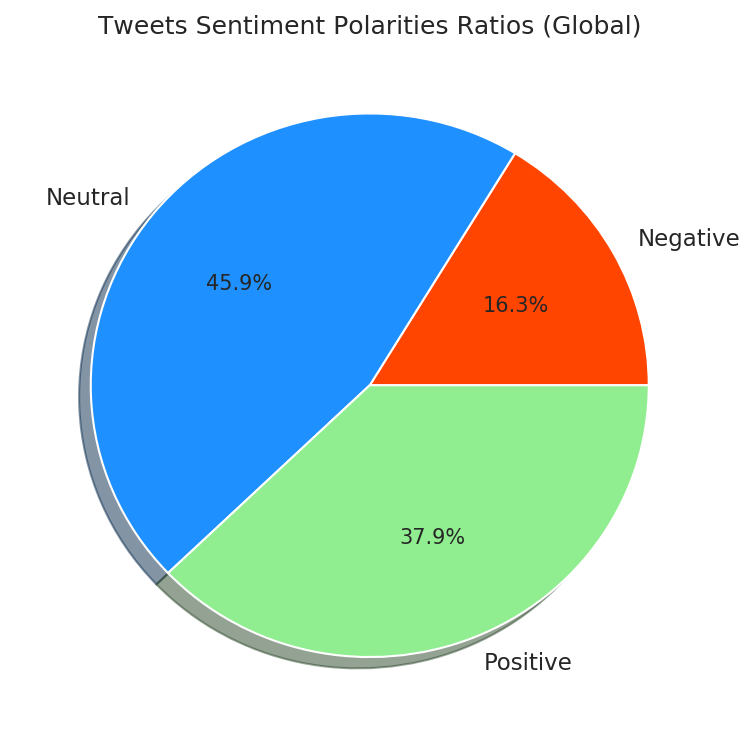

In [143]:
show_polarities_ratios(df_tweets, labels, colors, "Global")

Then for the individual hashtags:

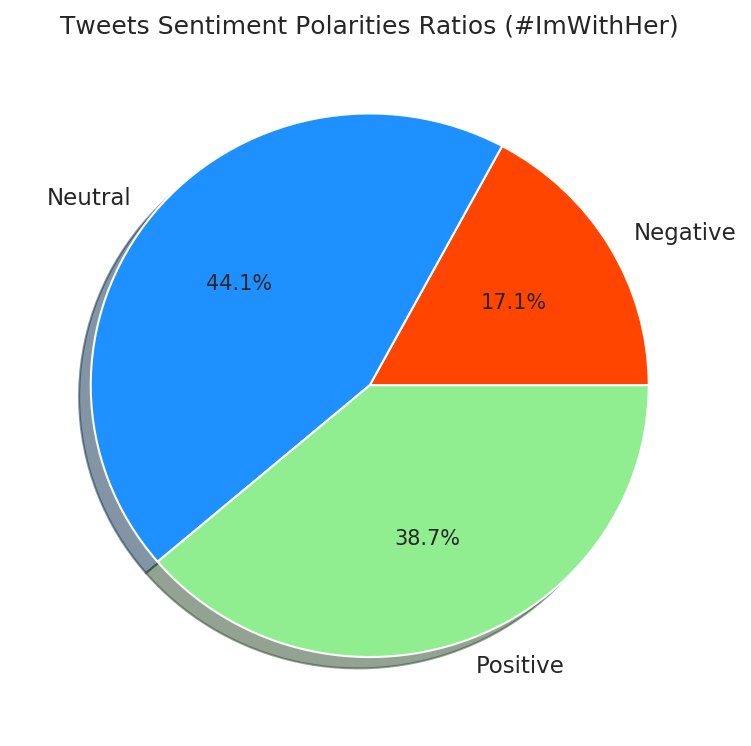

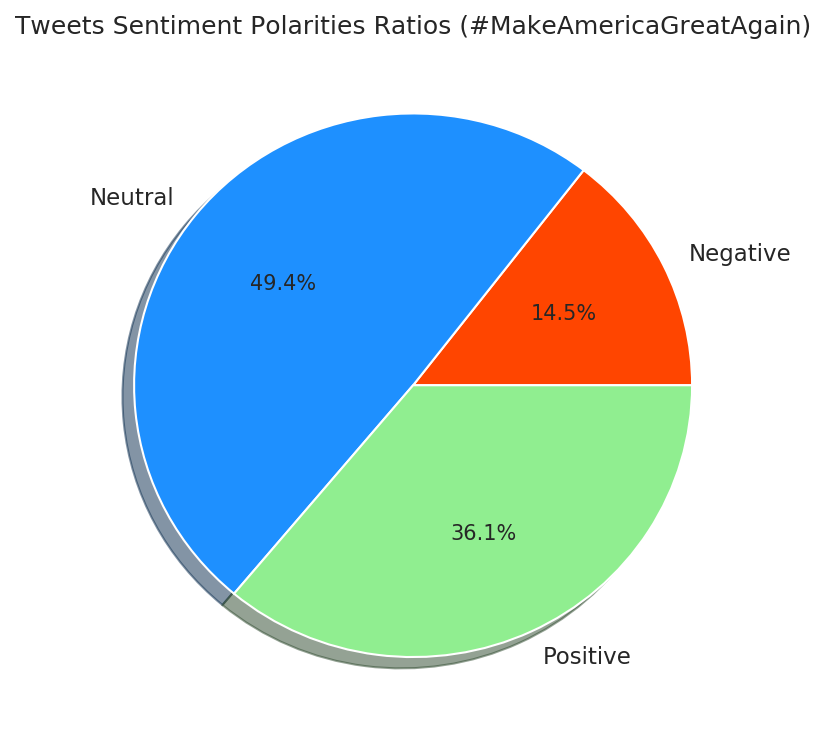

In [144]:
for h,H in zip(hashtags, hashtags_full):
    show_polarities_ratios(df_tweets[df_tweets["Hashtag"] == h], labels, colors, "#"+H)

- ***How does the sentiment score distribute? What's the average value? (Also by individual hashtag)***

In [268]:
def boxplot_from_dataframe(df, columns, title, filename, baseline=None):
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(5,6)
    fig.set_dpi(150)
    fig.set_tight_layout(False)
    
    ax.set_title(title, fontsize=12)
    df.boxplot(column=columns, ax=ax)
    if not baseline is None:
        ax.axhline(y=baseline, linestyle='--', color='red', alpha=0.5)
    
    plt.savefig(os.path.join(pictures_path,filename+".png"))
    plt.show()

In [151]:
avg_sentiment_score = df_tweets["Sentiment_Score"].describe()["mean"]
print("Average Sentiment Score (Global): %f" %avg_sentiment_score)

Average Sentiment Score (Global): 0.097428


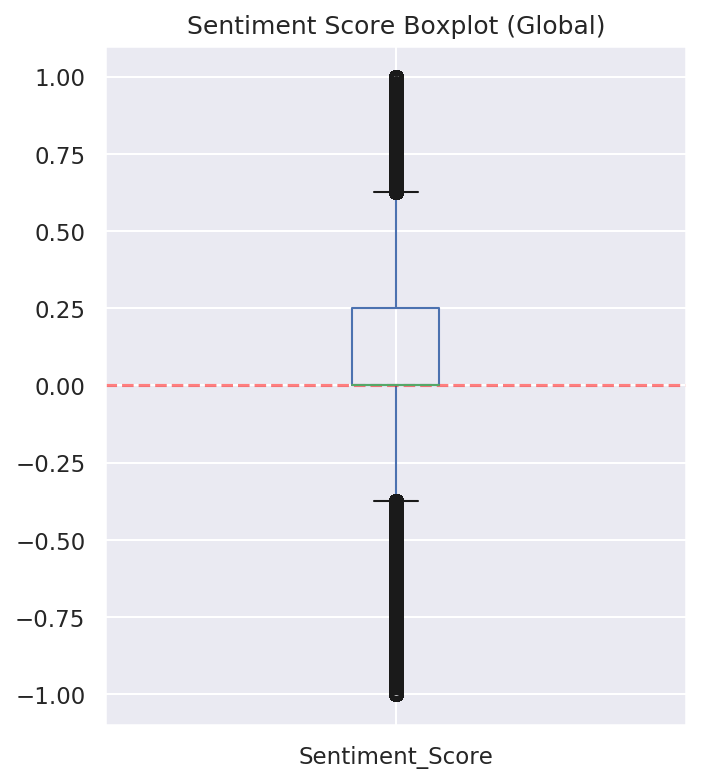

In [269]:
boxplot_from_dataframe(df_tweets, ["Sentiment_Score"], "Sentiment Score Boxplot (Global)", "sentiment_score_boxplot_global", baseline=0)

Hmm, apparently the vast majority of the neutral sentiment scores are messing up the boxplot and hiding the actual comparison between positive and negative sentiment. Let's not include the neutral scores then:

In [157]:
avg_sentiment_score = df_tweets[df_tweets["Sentiment_Polarity"] != 'neu']["Sentiment_Score"].describe()["mean"]
print("Average Sentiment Score (No Neutral): %f" %avg_sentiment_score)

Average Sentiment Score (No Neutral): 0.179959


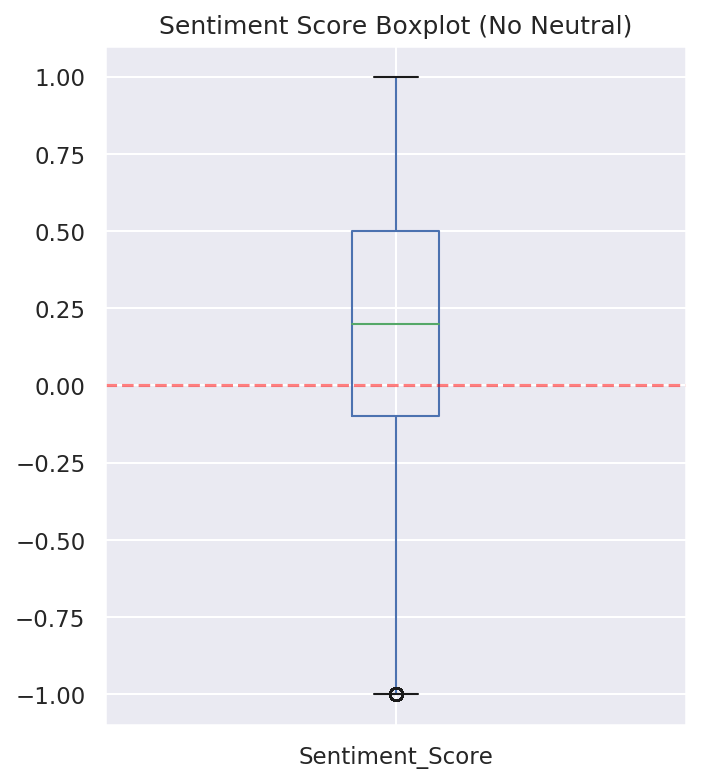

In [271]:
boxplot_from_dataframe(df_tweets[df_tweets["Sentiment_Polarity"] != 'neu'], ["Sentiment_Score"],
                       "Sentiment Score Boxplot (No Neutral)", "sentiment_score_boxplot_no_neutral", baseline=0)

This now better highlights the dominance of a positive sentiment among the politically controversial tweets I've considered. We could further show the details about the individual hashtags:

Average Sentiment Score (ImWithHer): 0.167769


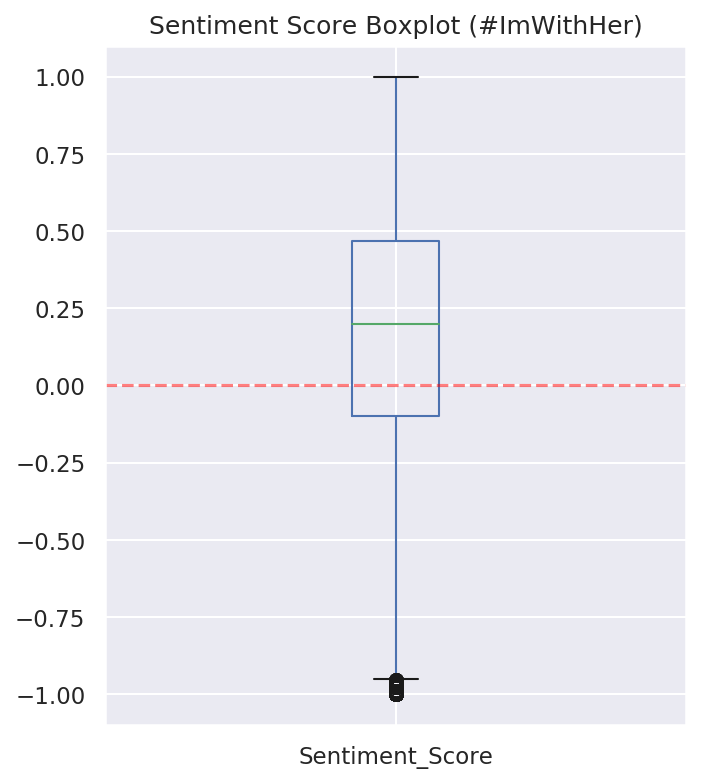

Average Sentiment Score (MakeAmericaGreatAgain): 0.207895


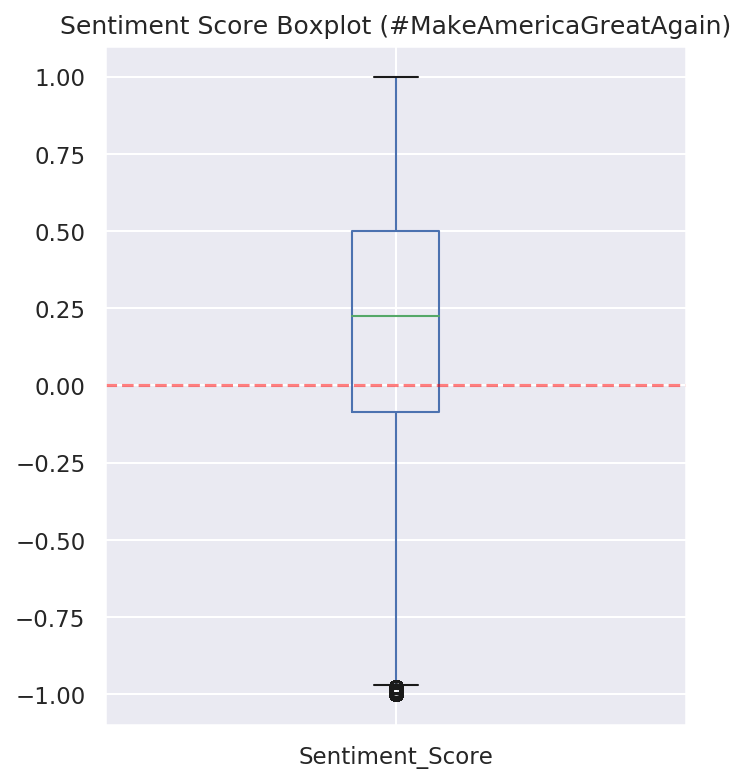

In [273]:
for h,H in zip(hashtags, hashtags_full):
    avg_sentiment_score = df_tweets[(df_tweets["Sentiment_Polarity"] != 'neu') & (df_tweets["Hashtag"] == h)]["Sentiment_Score"].describe()["mean"]
    print("Average Sentiment Score (%s): %f" %(H, avg_sentiment_score))
    boxplot_from_dataframe(df_tweets[(df_tweets["Sentiment_Polarity"] != 'neu') & (df_tweets["Hashtag"] == h)], ["Sentiment_Score"],
                           "Sentiment Score Boxplot (#%s)" %H, "sentiment_score_boxplot_%s" %h, baseline=0)

Overall, **#MAGA** tweets seem to be slightly more positive than the rival **#ImWithHer**.

## 2. Impact of Hashtags and relationship with sentiment polarity
The usage of hashtags in tweets might have an impact on determining the sentiment polarity, when hashtags are actually single words and understandable by the classifier, furthermore they might reflect additional features about Twitter users in terms of *how* do they tweet. The idea now is to show, based on (1) the considered political hashtag and (2) the sentiment polarity, what are the top hashtags that people use in their tweets.

### 2.1 Top supporting hashtags by main political hashtag
We do know that Twitter doesn't really impose a limit on how many hashtags one may use in a Tweet. Therefore, hashtags are actually a powerful way to enhance expressiveness of what a user wants to communicate in a short and handy way. It's very common indeed to see more than one hashtag showing up in the same tweet, but do all the hashtags that a single tweet text features relate with each other? In other words, if we consider political hashtags, do all the hashtags in the same tweet reflect the same political leaning?  
Showing which hashtags support the main ones we are analyzing may give an answer to these questions.

In [254]:
def plot_top_hashtags(x, y, labels, title, filename, linestyle, text_pos):
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(10,6)
    fig.set_dpi(150)
    fig.set_tight_layout(False)
    
    ax.plot(x, y, linestyle, linewidth=2)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Hashtag", fontsize=10, fontweight="bold")
    ax.set_ylabel("Tweets", fontsize=10, fontweight="bold")
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_xticklabels(labels, fontsize=8)
    ax.set_xticks(x)
    for l,x,y in zip(labels[:5],x[:5], y[:5]):
        ax.annotate(l, xy=(x,y), xycoords='data',
                            xytext=(70,-20) if not l in text_pos else text_pos[l], textcoords='offset points',ha='center', va='bottom',fontsize=12,color='blue',rotation=10,
                            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', ec="orange", alpha=0.3),
                            arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color="orange"))

    fig.subplots_adjust(bottom=0.3)
    plt.savefig(os.path.join(pictures_path, filename+".png"))
    plt.show()

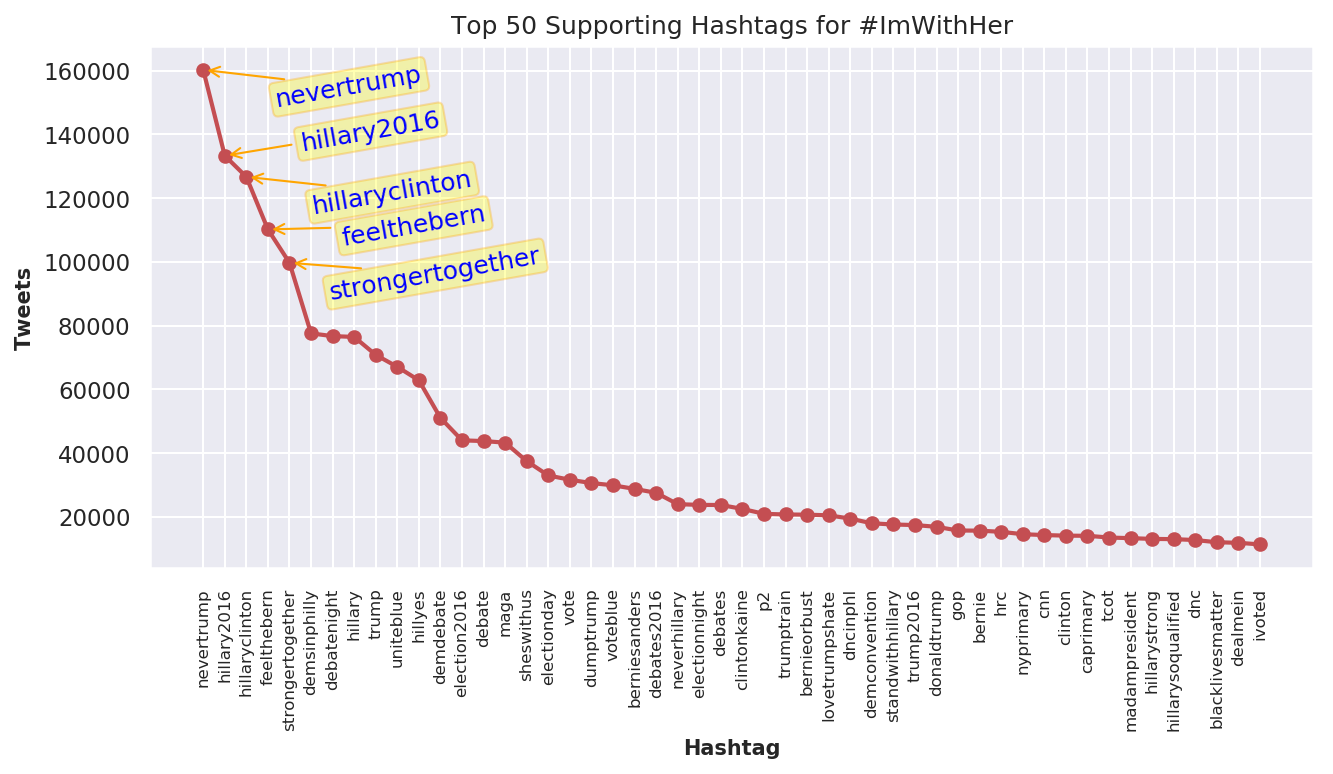

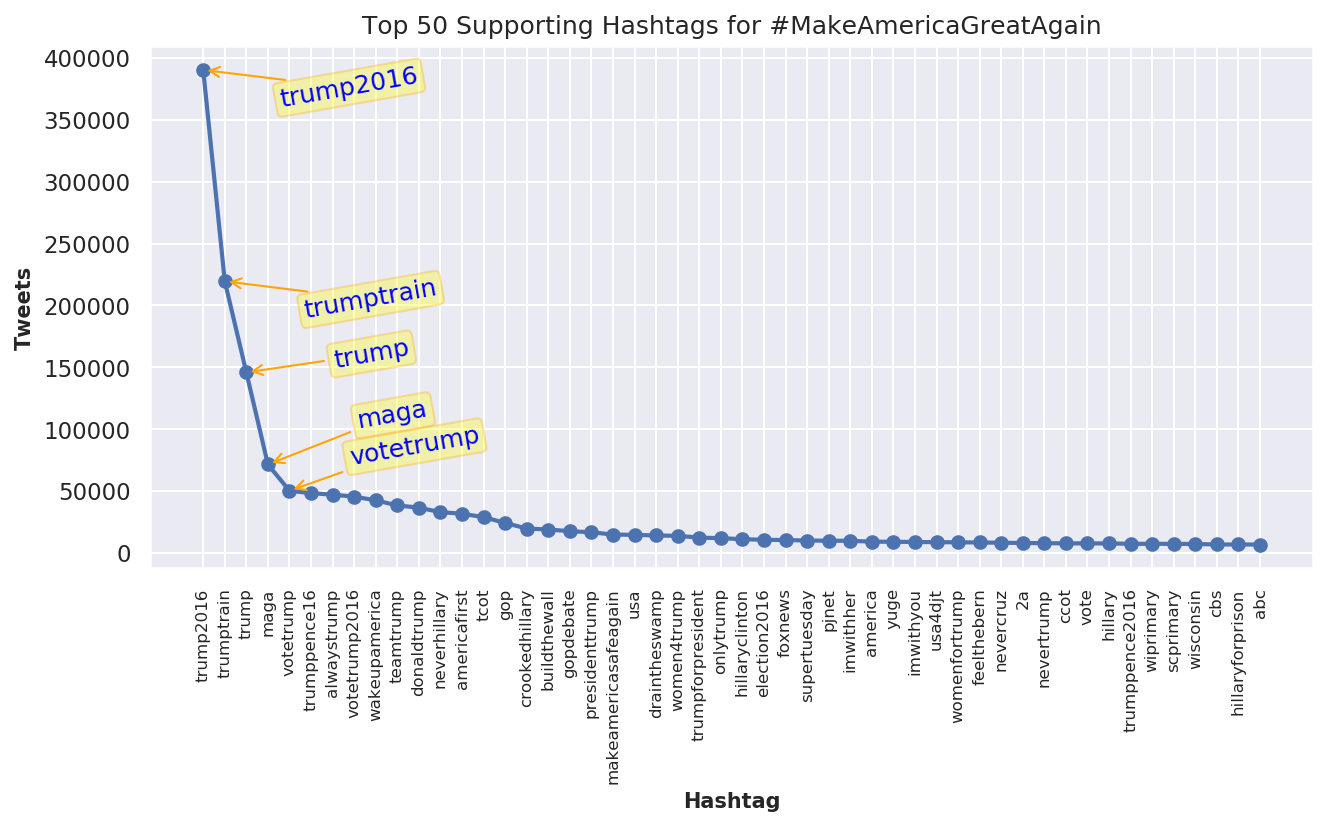

In [263]:
linestyles = {'imwithher': 'ro-', 'makeamericagreatagain': 'bo-'}
text_pos = {'hillary2016': (70,0), 'feelthebern': (70,-10), 'maga': (60,15), 'votetrump': (60,10), 'trump': (60,0)}
for h,H in zip(hashtags, hashtags_full):
    labels, y = zip(*sorted(extra_hashtags[h].items(), key=operator.itemgetter(1), reverse=True)[:50])
    x = range(1,len(labels)+1)
    plot_top_hashtags(x, y, labels, "Top 50 Supporting Hashtags for #"+H, "top_hashtags_"+h, linestyles[h], text_pos)

It's interesting to see a strong difference in how the scale for the values of the $y$-axis: in the case of **#ImWithHer**, we can see a much more well defined curve with decreasing values and no huge drops are visible between the individual values. By the other side, in the **#MAGA** case there's a clear value peak for hashtag `#Trump2016`, with a drop in almost half of the value for the subsequent hashtag `#TrumpTrain`. It's funny to see that the top supporting hashtag for Hillary's campaign, `#NeverTrump`, actually is a counter attack to Trump rather than a slogan pro-Hillary. The corresponding counter attack by Trump supporters, `#NeverHillary`, is only the 12th top frequent hashtag. However, the general trend in both cases, is that most of the supporting hashtags reflect the political leaning of the main political hashtag they relate to, i.e. liberals/democrats for #ImWithHer, conservatives/republicans for #MAGA.

This result would support the principle of the **echo chambers** and that there's also a stronger factor that makes people choose what to interact with on social networks like Twitter, which according to this example, turns out to be mostly content they feel aligned with.

### 2.2 *How many hashtags per Tweet*?
The amount of hashtags being used in a Tweet might represent an additional feature of users' behavior. Let's see if the supporters of the considered political hashtags tend to have common behavior in terms of how many hashtags they use in their tweets. A nice way to represent this would be to show the average amount of hashtags per Tweet for (1) both political hashtags and (2) both sentiment polarities (pos/neg).

[#ImWithHer] Number of unique tweets to consider: 2407406
count    2.407406e+06
mean     2.083717e+00
std      1.589009e+00
min      0.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      3.000000e+00
max      2.700000e+01
Name: Num_Hashtags, dtype: float64
[#ImWithHer] Average number of hashtags per tweet: 2.08


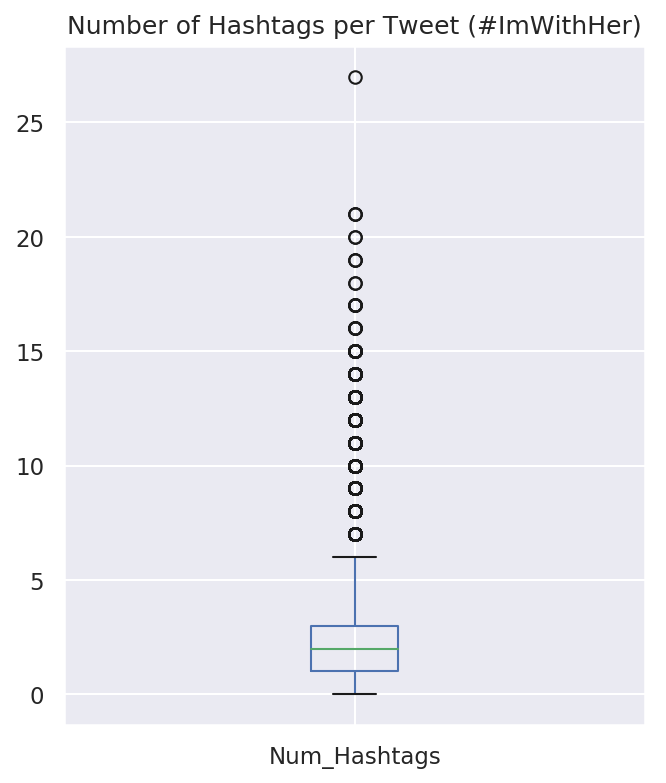

[#MakeAmericaGreatAgain] Number of unique tweets to consider: 1197063
count    1.197063e+06
mean     2.214027e+00
std      1.741011e+00
min      0.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      3.000000e+00
max      2.600000e+01
Name: Num_Hashtags, dtype: float64
[#MakeAmericaGreatAgain] Average number of hashtags per tweet: 2.21


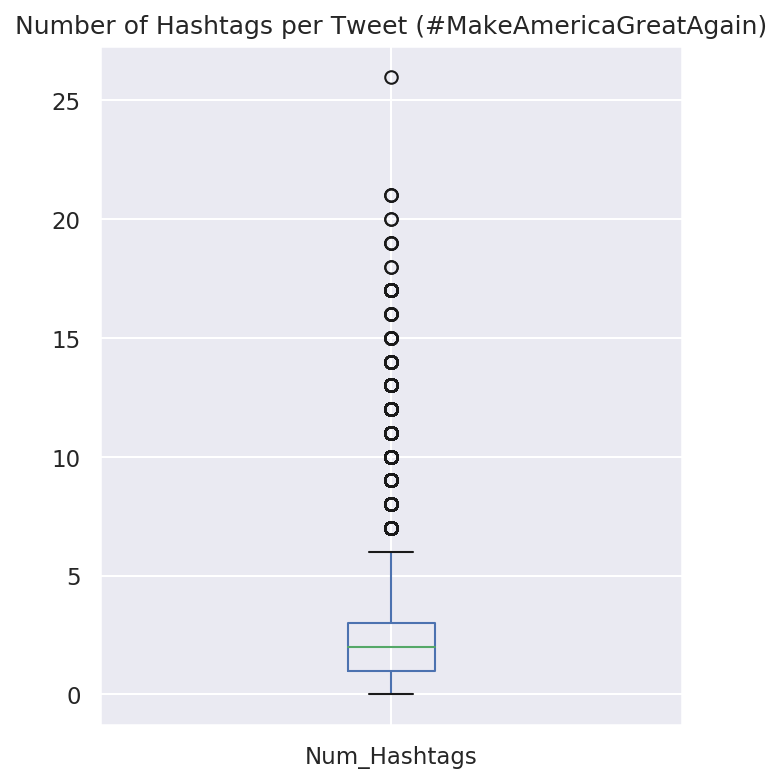

CPU times: user 13.6 s, sys: 500 ms, total: 14.1 s
Wall time: 13.6 s


In [222]:
%%time
for h,H in zip(hashtags, hashtags_full):
    tweets_ids = set(df_tweets[df_tweets["Hashtag"] == h]["ID"])
    print("[#%s] Number of unique tweets to consider: %d" %(H, len(tweets_ids)))
    data = pd.Series([len(t.tweet_dict["entities"]["hashtags"])
                      for t in hashtag_to_tweets[h]
                      if t.tweet_id in tweets_ids], name="Num_Hashtags")
    avg_hashtags_per_tweet = data.describe()["mean"]
    print(data.describe())
    print("[#%s] Average number of hashtags per tweet: %.2f" %(H, avg_hashtags_per_tweet))
    boxplot_from_dataframe(pd.DataFrame(data), "Num_Hashtags", "Number of Hashtags per Tweet (#%s)" %H, "hashtags_per_tweet_boxplot_"+h)

According to the results above, the number of hashtags per Tweet doesn't differ significantly when it comes to both political hashtags, they're actually almost identical:
- **#ImWithHer**: values range in $[0,27]$, with average value $\mu=2,08$;
- **#MAGA**: values range in $[0,26]$, with average value $\mu=2,21$.

We can't really say after all that any of the two political hashtags stands out for the number of hashtags per tweet. Let's see if **sentiment** instead plays a more significant role into this aspect:

[Positive] Number of unique tweets to consider: 1369857
count    437044.000000
mean          2.012303
std           1.623176
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          21.000000
Name: Num_Hashtags, dtype: float64
[Positive] Average number of hashtags per tweet: 2.01


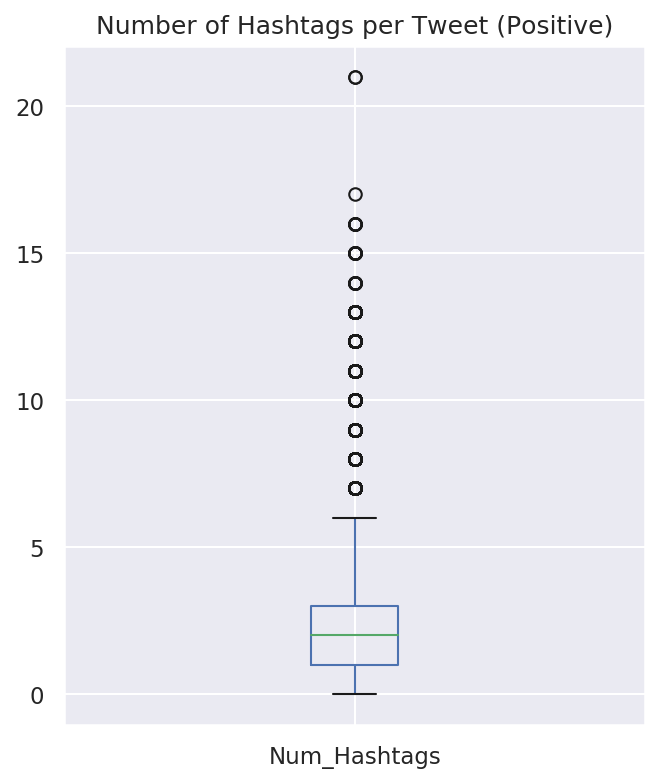

[Negative] Number of unique tweets to consider: 589187
count    176766.000000
mean          1.879485
std           1.548137
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          13.000000
Name: Num_Hashtags, dtype: float64
[Negative] Average number of hashtags per tweet: 1.88


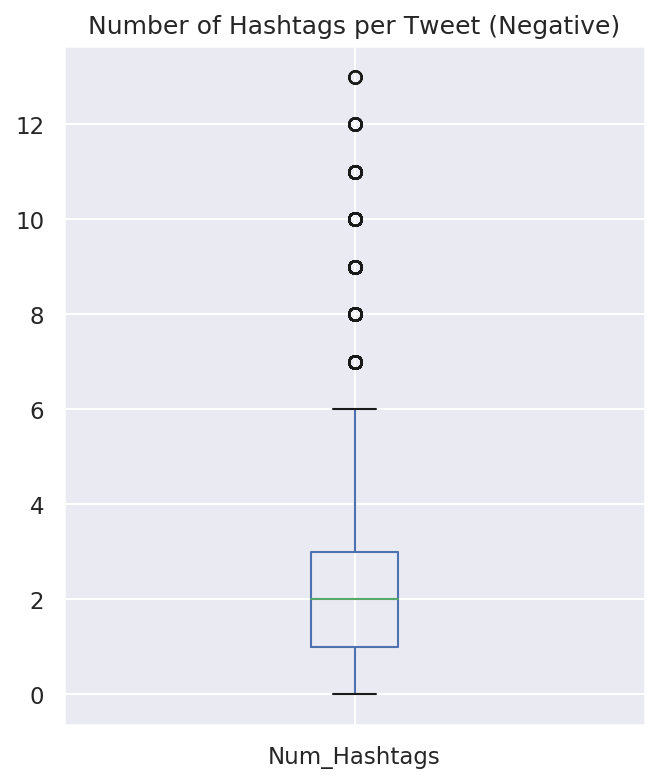

CPU times: user 5.69 s, sys: 460 ms, total: 6.15 s
Wall time: 5.65 s


In [225]:
%%time
for polarity, polarity_label in [('pos','Positive'), ('neg','Negative')]:
    tweets_ids = set(df_tweets[df_tweets["Sentiment_Polarity"] == polarity]["ID"])
    print("[%s] Number of unique tweets to consider: %d" %(polarity_label, len(tweets_ids)))
    data = pd.Series([len(t.tweet_dict["entities"]["hashtags"])
                      for t in hashtag_to_tweets[h]
                      if t.tweet_id in tweets_ids], name="Num_Hashtags")
    avg_hashtags_per_tweet = data.describe()["mean"]
    print(data.describe())
    print("[%s] Average number of hashtags per tweet: %.2f" %(polarity_label, avg_hashtags_per_tweet))
    boxplot_from_dataframe(pd.DataFrame(data), "Num_Hashtags", "Number of Hashtags per Tweet (%s)" %polarity_label, "hashtags_per_tweet_boxplot_"+polarity)

Again, not really a significant difference:
- Tweets with **Positive** sentiment score: values range in $[0,21]$ with average value $\mu=2,01$
- Tweets with **Negative** sentiment score: values range in $[0,13]$ with average value $\mu=1,88$

Given the slight difference in favour of the positive tweets, maybe just a hint that people who tend to spread positivity in Twitter also try to reach out to more people by including more hashtags? ...

### 2.3 *How many words per Tweet?*
Why not considering, at this point, the potential correlation that exists between the amount of content of each tweet with the hashtag and the sentiment. Does positive/negative sentiment relate more with longer or shorter tweets? Let's find out.

In [492]:
def get_word_counts_by_column_value(df_tweets, column, value):
    return pd.Series([len(nltk.word_tokenize(r["Cleaned"])) for _,r in df_tweets[df_tweets[column] == value].iterrows()], dtype=np.uint8)

def get_dataframe_from_word_counts_list(word_counts_list):
    return pd.DataFrame(word_counts_list, columns=['Words']).groupby(by="Words").size().reset_index(name="Count")

def get_word_counts_dict_from_dataframe(word_counts_df):
    return dict(zip(word_counts_df["Words"], word_counts_df["Count"]))

In [493]:
%%time
word_counts = {h: get_word_counts_by_column_value(df_tweets, "Hashtag", h) for h in hashtags}

CPU times: user 26min 9s, sys: 21.7 s, total: 26min 30s
Wall time: 26min 8s


In [494]:
for h in word_counts:
    print("[%s] Words per Tweet Basic stats:" %h)
    print(word_counts[h].describe(percentiles=[.25,.5,.75,.9]))

[makeamericagreatagain] Words per Tweet Basic stats:
count    1.197063e+06
mean     1.463734e+01
std      5.215317e+00
min      1.000000e+00
25%      1.100000e+01
50%      1.400000e+01
75%      1.800000e+01
90%      2.200000e+01
max      1.170000e+02
dtype: float64
[imwithher] Words per Tweet Basic stats:
count    2.407406e+06
mean     1.647994e+01
std      5.746096e+00
min      1.000000e+00
25%      1.200000e+01
50%      1.600000e+01
75%      2.100000e+01
90%      2.400000e+01
max      1.020000e+02
dtype: float64


The average number of words per tweet is **16,47** for **#ImWithHer** tweets and **14,67** for **#MAGA** tweets. Yet, in both cases, 90% of the tweets have less than 22/24 words. 

In [495]:
# Change format of data structure
word_counts = {h: get_dataframe_from_word_counts_list(word_counts[h]) for h in word_counts}
word_counts = {h: get_word_counts_dict_from_dataframe(word_counts[h]) for h in word_counts}

In [507]:
def plot_word_counts_comparison(word_counts, labels_dict, linestyles_dict, filename):
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(10,6)
    fig.set_dpi(150)
    fig.set_tight_layout(False)

    stop = max(set().union(*[word_counts[h].keys() for h in word_counts]))
    x = np.arange(1,stop+1)
    for h in word_counts:
        y = [word_counts[h][i] if i in word_counts[h] else 0 for i in x]
        ax.plot(x, y, linestyles_dict[h], label=labels_dict[h])
    ax.set_xticks(x[::5])
    ax.set_xticklabels(x[::5], fontsize=8)
    ax.set_title("Comparing number of words per tweet for different hashtags")
    ax.set_xlabel("Words per Tweet")
    ax.set_ylabel("Frequency")
    ax.legend()

    plt.savefig(os.path.join(pictures_path, filename+".png"))
    plt.show()

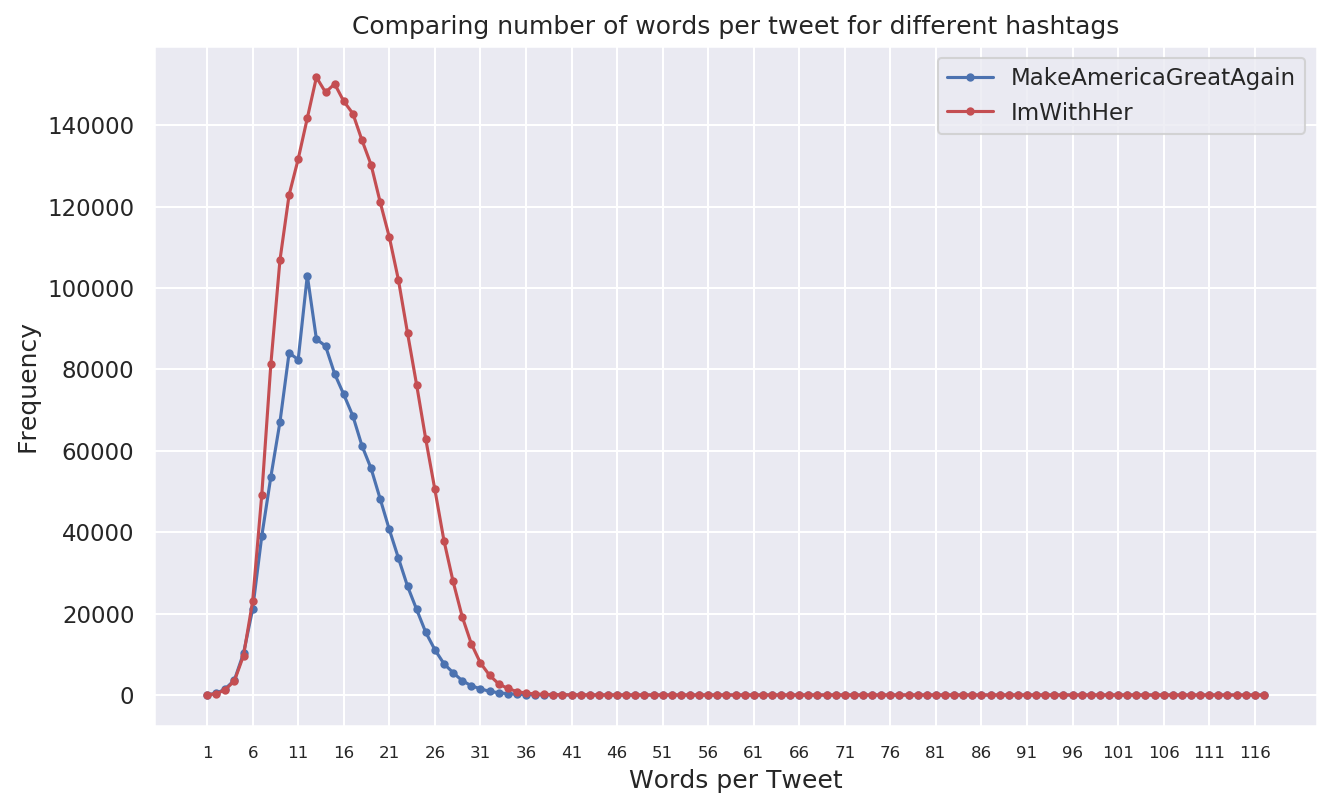

In [509]:
linestyles_dict = {"imwithher": 'r.-', "makeamericagreatagain": 'b.-'}
plot_word_counts_comparison(word_counts, dict(zip(hashtags, hashtags_full)), linestyles_dict, "words_per_tweet_by_hashtag_comparison")

In both cases, although the curve for the **#ImWithHer** hashtag has a higher peak due to its larger amount of tweets, it's clear that most of the tweets have less than 30 words.

## 3. *What do you Tweet*? Simplified text classification by content of Tweet and sentiment
The last step I'm gonna work on concerning NLP is **text classification**: it is one of the important and typical tasks in supervised machine learning. Assigning categories to documents, which can be a web page, library book, media articles, gallery etc. has many applications like e.g. spam filtering, email routing, sentiment analysis etc. In our context one might wonder what we actually want to predict since we don't really have labeled data. Well, if we consider the hashtag to be the label/target we want to predict, the goal is to understand whether the full content of the tweets of the political hashtags we've analyzed so far does play a role in user behavior, which would represent an association between the content of the tweet and the political leaning. Long story short, I want to provide an answer to the question: *Does what you tweet make you look more democrat or republican?* Technically speaking, I want to train a hashtag classifier to predict whether a tweet relates more to the **#ImWithHer** or **#MAGA** hashtag, based on what people tweet when they use such hashtag (i.e. what words they use). For sake of precision, it makes more sense to consider only those tweets that didn't feature both hashtags, so that we minimize ambiguity and ease the job of the classifier. I would point out, however, that the goal of this task is not really to predict the *political leaning* of a tweet/user: the fact that people use a specific hashtag doesn't necessarily mean that they actually feel aligned with the principle or concept it's meant for, it could also be used to express disagreement with it.

In order to address this task, we must first complete the cleaning of the tweets text as defined by the *advanced cleaning function*, which additionally deals with stemming, stop-words and short words:

In [518]:
%%time
df_tweets["Cleaned_Full"] = df_tweets.apply(lambda r: clean_tweet_advanced(r["Cleaned"]), axis=1)

CPU times: user 4h 21min 43s, sys: 4min 6s, total: 4h 25min 49s
Wall time: 4h 25min 45s


We can show some basic stats about the fully cleaned texts, for example:
- ***What are the most common words in the entire corpus we've collected?***

In [533]:
# Dynamically update corpus for each cleaned tweet we're iterating on
corpus_global = Counter()
num_rows = len(df_tweets[df_tweets["Hashtag"] != 'both'].index)
print("Building Tweets corpus from %d rows..." %num_rows)
checkpoint = num_rows/10
for i,r in df_tweets[df_tweets["Hashtag"] != 'both'].iterrows():
    tokens = r["Cleaned_Full"].split()
    corpus_global.update(tokens)
    if i % checkpoint == 0:
        print("Processed %d rows..." %i)
print("Done!")
print("%d unique words in corpus" %len(corpus_global.keys()))

Building Tweets corpus from 3604469 rows...
Processed 0 rows...
Processed 360446 rows...
Processed 720892 rows...
Processed 1081338 rows...
Processed 1441784 rows...
Processed 1802230 rows...
Processed 2162676 rows...
Processed 2523122 rows...
Processed 2883568 rows...
Processed 3244014 rows...
Processed 3604460 rows...
Done!
457193 unique words in corpus


- ***What are the most common words if we only consider #ImWithHer/#MAGA tweets and positive/negative tweets?***

In [537]:
%%time
# Most common words by hashtag
hashtag_corpus = {}
for h in hashtags:
    corpus = Counter()
    num_rows = len(df_tweets[df_tweets["Hashtag"] == h].index)
    print("[%s] Building Tweets corpus from %d rows..." %(h, num_rows))
    checkpoint = num_rows/10
    for i,r in df_tweets[df_tweets["Hashtag"] == h].iterrows():
        tokens = r["Cleaned_Full"].split()
        corpus.update(tokens)
        if i % checkpoint == 0:
            print("[%s] Processed %d rows..." %(h,i))
    hashtag_corpus[h] = corpus
    print("[%s] Done!" %h)
    print("[%s] %d unique words in corpus" %(h,len(corpus.keys())))

[imwithher] Building Tweets corpus from 2407406 rows...
[imwithher] Processed 0 rows...
[imwithher] Processed 240740 rows...
[imwithher] Processed 481480 rows...
[imwithher] Processed 722220 rows...
[imwithher] Processed 962960 rows...
[imwithher] Processed 1203700 rows...
[imwithher] Processed 1444440 rows...
[imwithher] Processed 1685180 rows...
[imwithher] Processed 2166660 rows...
[imwithher] Processed 2407400 rows...
[imwithher] Done!
[imwithher] 334693 unique words in corpus
[makeamericagreatagain] Building Tweets corpus from 1197063 rows...
[makeamericagreatagain] Processed 2513826 rows...
[makeamericagreatagain] Processed 2633532 rows...
[makeamericagreatagain] Processed 2753238 rows...
[makeamericagreatagain] Processed 2872944 rows...
[makeamericagreatagain] Processed 2992650 rows...
[makeamericagreatagain] Processed 3112356 rows...
[makeamericagreatagain] Processed 3232062 rows...
[makeamericagreatagain] Processed 3351768 rows...
[makeamericagreatagain] Processed 3471474 rows

In [539]:
# Most common words by sentiment polarity
polarity_corpus = {}
for polarity in ['pos','neg']:
    corpus = Counter()
    num_rows = len(df_tweets[df_tweets["Sentiment_Polarity"] == polarity].index)
    print("[%s] Building Tweets corpus from %d rows..." %(polarity, num_rows))
    checkpoint = num_rows/10
    for i,r in df_tweets[df_tweets["Sentiment_Polarity"] == polarity].iterrows():
        tokens = r["Cleaned_Full"].split()
        corpus.update(tokens)
        if i % checkpoint == 0:
            print("[%s] Processed %d rows..." %(polarity,i))
    polarity_corpus[polarity] = corpus
    print("[%s] Done!" %polarity)
    print("[%s] %d unique words in corpus" %(polarity,len(corpus.keys())))

[pos] Building Tweets corpus from 1369857 rows...
[pos] Processed 410955 rows...
[pos] Processed 547940 rows...
[pos] Processed 821910 rows...
[pos] Processed 1095880 rows...
[pos] Processed 1369850 rows...
[pos] Processed 1506835 rows...
[pos] Processed 1780805 rows...
[pos] Processed 2602715 rows...
[pos] Processed 3150655 rows...
[pos] Processed 3424625 rows...
[pos] Done!
[pos] 215841 unique words in corpus
[neg] Building Tweets corpus from 589187 rows...
[neg] Processed 58918 rows...
[neg] Processed 235672 rows...
[neg] Processed 294590 rows...
[neg] Processed 1060524 rows...
[neg] Processed 1119442 rows...
[neg] Processed 1590786 rows...
[neg] Processed 2003212 rows...
[neg] Processed 2415638 rows...
[neg] Processed 3122654 rows...
[neg] Processed 3535080 rows...
[neg] Processed 3593998 rows...
[neg] Done!
[neg] 128393 unique words in corpus


In [634]:
for h in hashtags:
    print("[%s] Top 10 most common tokens in corpus:" %h)
    print(sorted(hashtag_corpus[h].items(), key=operator.itemgetter(1), reverse=True)[:10])
print("\n")
for polarity in polarity_corpus:
    print("[%s] Top 10 most common tokens in corpus:" %polarity)
    print(sorted(polarity_corpus[polarity].items(), key=operator.itemgetter(1), reverse=True)[:10])

[imwithher] Top 10 most common tokens in corpus:
[(u'imwithher', 1980613), (u'hillary', 423490), (u'trump', 345514), (u'vote', 257958), (u'clinton', 195700), (u'debate', 122705), (u'woman', 114490), (u'nevertrump', 109120), (u'make', 105025), (u'bernie', 103486)]
[makeamericagreatagain] Top 10 most common tokens in corpus:
[(u'makeamericagreatagain', 980446), (u'trump', 601388), (u'trumptrain', 123579), (u'vote', 90188), (u'america', 64094), (u'donald', 57602), (u'votetrump', 53854), (u'thank', 51532), (u'person', 46068), (u'great', 45334)]


[neg] Top 10 most common tokens in corpus:
[(u'imwithher', 328008), (u'trump', 157817), (u'makeamericagreatagain', 133347), (u'hillary', 72029), (u'vote', 44583), (u'clinton', 34851), (u'person', 29928), (u'woman', 24584), (u'debate', 23584), (u'hate', 23078)]
[pos] Top 10 most common tokens in corpus:
[(u'imwithher', 766162), (u'makeamericagreatagain', 348940), (u'trump', 327260), (u'hillary', 171902), (u'vote', 130186), (u'great', 90173), (u'goo

*Show WordClouds*

Let's first highlight again what's the frequency of entries with each label (from now on, by saying label/target I mean the `Hashtag` attribute of our dataset):

In [540]:
total_tweets = len(df_tweets[df_tweets["Hashtag"] != "both"].index)
print("Total unique Tweets in the dataset: %d" %total_tweets)
for h in hashtags:
    total_tweets_by_hashtag = len(df_tweets[df_tweets["Hashtag"] == h].index)
    print("Total unique Tweets with hashtag '%s': %d (%.2f%% of %d)" %(h, total_tweets_by_hashtag,
                                                                       get_relative_percentage(total_tweets_by_hashtag, total_tweets), total_tweets))

Total unique Tweets in the dataset: 3604469
Total unique Tweets with hashtag 'imwithher': 2407406 (66.79% of 3604469)
Total unique Tweets with hashtag 'makeamericagreatagain': 1197063 (33.21% of 3604469)


As we're considering it now, the dataset is unbalanced (i.e. classes are not evenly distributed): this actually represents a problem, since unbalanced classes often lead to misclassification issues and the overfitting problem, well known in the ML area. In general, a classifier would think: *what's the best thing to do in order to achieve the highest accuracy? Well, I look at the data, the best and most clever thing to do is to always predict the largest class*.

What can be easily done and that fits the current context nicely, is **under-sampling** the largest class, mainly because of the size of the data (we're talking about millions of records anyway if we under-sample). Additionally, let's convert the label column to a binary column, with 0/1 possible values (0 == `#ImWithHer` and 1 == `#MAGA`).

In [549]:
target_dict = {'imwithher': 0, 'makeamericagreatagain': 1, 'both': -1}

In [550]:
def get_target_binary_value(h, target_dict):
    return target_dict[h]

In [551]:
df_tweets["target"] = df_tweets.apply(lambda r: get_target_binary_value(r["Hashtag"], target_dict), axis=1)

In [552]:
# Under-sample #ImWithHer dataset

# Get number of tweets of the minor class
len_minor_class = len(df_tweets[df_tweets["Hashtag"] == 'makeamericagreatagain'].index)

# Get indices of tweets of larger class
larger_class_indices = df_tweets[df_tweets["Hashtag"] == 'imwithher'].index

# Get indices of tweets of minor class
minor_class_indices = df_tweets[df_tweets["Hashtag"] == 'makeamericagreatagain'].index

# Random sample of tweets from larger class
random_indices_larger_class = np.random.choice(larger_class_indices, len_minor_class, replace=False)

# Concatenate random indices from larger class with indices from minor class
indices_balanced = np.concatenate([random_indices_larger_class, minor_class_indices])

# Build balanced dataframe from balanced indices
df_tweets_balanced = df_tweets.loc[indices_balanced]

Everything has now been set for the text classification task.

### 3.1 Feature Extraction: Bag-Of-Words and TF-IDF
To analyze pre-processed data, it needs to be converted into features. Depending upon the usage, text features can be constructed using assorted techniques like Bag-of-Words, TF-IDF among the most common ones.

In [575]:
bow_vectorizer = CountVectorizer(max_features=1000)
# bag-of-words feature matrix
bow_matrix = bow_vectorizer.fit_transform(df_tweets_balanced['Cleaned_Full'])

In [576]:
# TF-IDF feature matrix (convert from BOW matrix)
tfidf_transformer = TfidfTransformer()
tfidf_matrix = tfidf_transformer.fit_transform(bow_matrix)

In [577]:
print('(BOW) Shape of Sparse Matrix:', bow_matrix.shape)
print('(BOW) Amount of Non-Zero occurrences:', bow_matrix.nnz)
print('(TF-IDF) Shape of Sparse Matrix:', tfidf_matrix.shape)
print('(TF-IDF) Amount of Non-Zero occurrences:', tfidf_matrix.nnz)

(BOW) Shape of Sparse Matrix: (2394126, 1000)
(BOW) Amount of Non-Zero occurrences: 12296392
(TF-IDF) Shape of Sparse Matrix: (2394126, 1000)
(TF-IDF) Amount of Non-Zero occurrences: 12296392


### 3.2 Building the model and performance evaluation
It's time now to choose a classifier: A simple **Naive Bayes** would be a good start, then we can try to compare the performance by trying also linear models such as **Logistic Regression** and **SVM (Support Vector Machines)**.

In [626]:
def split_dataset(features, label):
    return train_test_split(features, label, test_size=0.2, shuffle=True)

def fit_clf(clf_alg, X_train, y_train):
    if clf_alg == 'NB':
        return MultinomialNB().fit(X_train, y_train)
    if clf_alg == 'LR':
        return LogisticRegression().fit(X_train, y_train)
    if clf_alg == 'SVM':
        return SGDClassifier(max_iter=1000, tol=1e-3).fit(X_train, y_train)
    
def predict_target(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    print('Accuracy score: ',accuracy_score(y_test, y_pred))
    print('\n')
    print('Confusion matrix: \n',confusion_matrix(y_test,y_pred))
    print('\n')
    print(classification_report(y_test, y_pred))
    
def split_fit_predict(features, label, clf_type):
    X_train, X_test, y_train, y_test = split_dataset(features, label)
    clf = fit_clf(clf_type, X_train, y_train)
    predict_target(clf, X_test, y_test)

In [627]:
for clf_type in ['NB','SVM','LR']:
    for features_type, features in zip(["BOW", "TF-IDF"], [bow_matrix, tfidf_matrix]):
        print("--- BUILDING MODEL WITH %s FEATURES MATRIX AND %s CLASSIFIER ---" %(features_type, clf_type))
        split_fit_predict(bow_matrix, df_tweets_balanced["target"], clf_type)
        print("\n")

--- BUILDING MODEL WITH BOW FEATURES MATRIX AND NB CLASSIFIER ---
Accuracy score:  0.9484092342521083


Confusion matrix: 
 [[229332   9757]
 [ 14946 224791]]


             precision    recall  f1-score   support

          0       0.94      0.96      0.95    239089
          1       0.96      0.94      0.95    239737

avg / total       0.95      0.95      0.95    478826



--- BUILDING MODEL WITH TF-IDF FEATURES MATRIX AND NB CLASSIFIER ---
Accuracy score:  0.9485282754069327


Confusion matrix: 
 [[229080   9897]
 [ 14749 225100]]


             precision    recall  f1-score   support

          0       0.94      0.96      0.95    238977
          1       0.96      0.94      0.95    239849

avg / total       0.95      0.95      0.95    478826



--- BUILDING MODEL WITH BOW FEATURES MATRIX AND SVM CLASSIFIER ---
Accuracy score:  0.9508109417617255


Confusion matrix: 
 [[226704  12681]
 [ 10872 228569]]


             precision    recall  f1-score   support

          0       0.95   

In [637]:
# Backup DF
df_tweets.to_csv(os.path.join(data_dir, "df_tweets_nlp.csv"), index=False, encoding='utf-8')

## 4. Impact of sentiment polarity on network structure
*See correlation between some network metrics (e.g. avg degree, clustering coefficient) and the average positive/negative sentiment to demonstrate whether negative/positive sentiment drives more engagement in network structure (e.g. scatter plot with avg sentiment score over network metric, where each point represents a hashtag)*